# ***Facial Emotion Recognition***

Raquel Benjumea Puig; NIA: 251235

Mar de la Fuente Villuendas; NIA: 253535

Naia Gorostiaga Muruamendiaraz; NIA: 253149

#Load data (discrete)





**DATASET FER:**

The FER-2013 dataset consists in a set of 48x48 grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

Import of libraries and dataset

In [1]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import tensorflow as tf
print("GPU Available:", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available: True


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.io as sio
from google.colab import drive
import os
import zipfile
import random
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, GlobalMaxPooling2D, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn import set_config
from sklearn.metrics import accuracy_score
import tensorflow.keras.backend as K
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.utils import plot_model


In [5]:
# Mount Google Drive
drive.mount('/content/drive')
#data_path = '/content/drive/Shareddrives/Deep practiques/Projecte final/Data/'
#results_path = '/content/drive/Shareddrives/Deep practiques/Projecte final/Results/'

data_path = '/content/drive/My Drive/Projecte final/Data/'
results_path = '/content/drive/My Drive/Projecte final/Results/'


#data_path = '/content/drive/My Drive/3 upf/Deep Learning/Projecte final/Data/'
#results_path = '/content/drive/My Drive/3 upf/Deep Learning/Projecte final/Results/'


#data_path = '/content/drive/My Drive/Projecte final/Data/'
#results_path = '/content/drive/My Drive/Projecte final/Results/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#data_path = '/content/drive/My Drive/Projecte final/Data/'
#results_path = '/content/drive/My Drive/Projecte final/Results/'
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

train_dir = data_path+'/train'
test_dir = data_path+'/test'

# Define paths
train_zip_path = data_path+'/train.zip'
test_zip_path = data_path+'/test.zip'

# Unzip train.zip
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/train')

# Unzip test.zip
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/test')

# Verify the extraction
print("Train folder contents:")
print(os.listdir('/content/train/train'))
print("\nTest folder contents:")
print(os.listdir('/content/test/test'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train folder contents:
['happy', 'disgust', 'sad', 'neutral', 'angry', 'fear', 'surprise']

Test folder contents:
['happy', 'disgust', 'sad', 'neutral', 'angry', 'fear', 'surprise']


In [8]:
# Define transformation
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.RandomHorizontalFlip(),            # Apply horizontal flip
    transforms.RandomRotation(5),                 # Apply random rotation (degrees) -> important to set a small angle
    transforms.ToTensor(),                        # Convert images to PyTorch tensors
    transforms.Normalize(mean = [.5], std = [.5])
])


# Load datasets
full_train_dataset = datasets.ImageFolder('/content/train/train', transform=transform)
test_dataset = datasets.ImageFolder('/content/test/test', transform=transform)

# Calculate the size of training and validation datasets
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # shuffle=True to improve generalization
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)     # shuffle=False for validation
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)   # shuffle=False for consistent evaluation

# Check the class names
print(train_dataset.dataset.classes)          # Use dataset attribute to access original dataset classes
print(test_dataset.classes)
classes = test_dataset.classes

# Get class number
n_classes = len(train_dataset.dataset.classes)
print(f'There are {n_classes} classes.')

# Print the sizes of each dataset
print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
There are 7 classes.
Train dataset size: 22967
Validation dataset size: 5742
Test dataset size: 7178


Image batch shape: torch.Size([64, 1, 48, 48])
Labels batch shape: torch.Size([64])


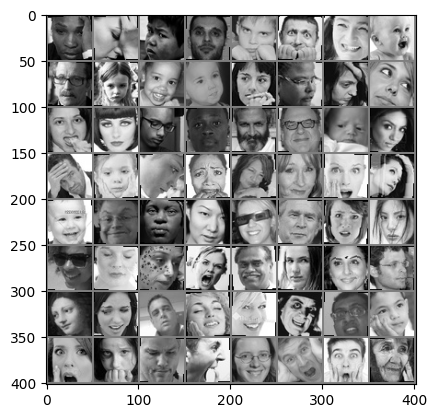

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Use the next function

# Print the shape of the images and labels
print(f"Image batch shape: {images.shape}")
print(f"Labels batch shape: {labels.shape}")

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join('%5s' % train_dataset.dataset.classes[labels[j]] for j in range(len(labels))))

Check dataset distribution

In [10]:
def plot_no_of_images(training_folder):
    categories = []
    image_counts = []

    for category in os.listdir(training_folder):
        category_path = os.path.join(training_folder, category)
        if os.path.isdir(category_path):
            categories.append(category)
            image_count = len(os.listdir(category_path))
            image_counts.append(image_count)

    plt.figure(figsize=(10, 6))
    plt.bar(categories, image_counts, color='royalblue', width=0.5)
    plt.xlabel('Categories')
    plt.ylabel('Number of Images')
    plt.title('Number of Images in Each Category')
    plt.xticks(rotation=45, fontsize=10)
    plt.show()



  sad   sad   sad neutral angry  fear happy happy neutral   sad happy neutral  fear   sad   sad angry neutral neutral neutral neutral happy happy  fear neutral   sad angry  fear  fear   sad happy surprise neutral happy happy neutral neutral happy happy  fear neutral happy neutral   sad angry happy neutral happy neutral neutral  fear   sad happy happy angry surprise neutral surprise   sad   sad angry happy   sad  fear neutral


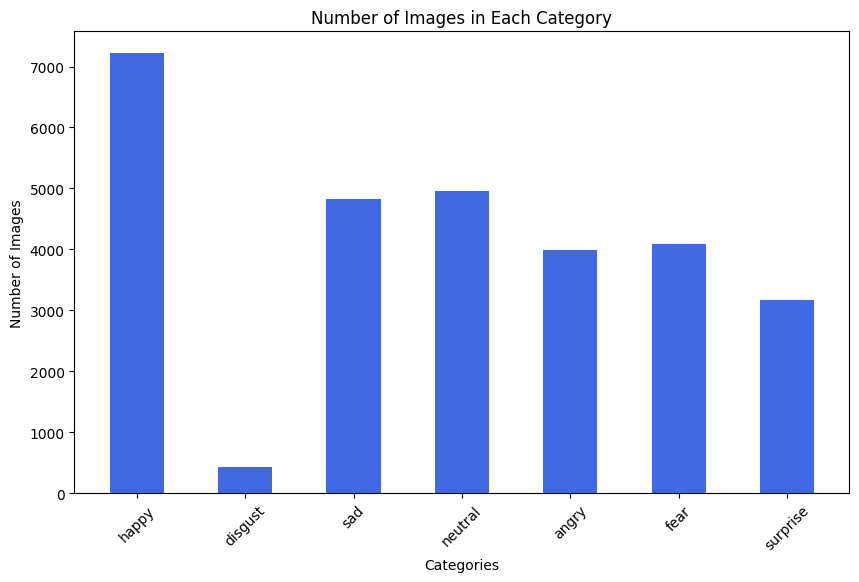

In [11]:
plot_no_of_images('/content/train/train/')

# Discrete models

Train pre-exisitng models

### VGG

In [12]:
import torch
import torch.nn as tnn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import confusion_matrix

LEARNING_RATE = 0.01
EPOCH = 15


trainLoader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
testLoader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


def vgg_fc_layer(size_in, size_out):
    layer = tnn.Sequential(
        tnn.Linear(size_in, size_out),
        tnn.BatchNorm1d(size_out),
        tnn.ReLU()
    )
    return layer


def compute_accuracy(data_loader):
    vgg16.eval()
    correct_pred, num_examples = 0, 0
    for batch_idx, (images, labels) in enumerate(data_loader):
        images = images.cuda()
        labels = labels.cuda()
        _, outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        num_examples += labels.size(0)
        correct_pred += (predicted.cuda() == labels).sum()

    return correct_pred.float()/num_examples * 100


class VGG16(tnn.Module):
    def __init__(self, n_classes=n_classes):
        super(VGG16, self).__init__()

        self.block_1 = tnn.Sequential(
                tnn.Conv2d(in_channels=1,
                          out_channels=32,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                tnn.ReLU(),
                #tnn.MaxPool2d(kernel_size=(2, 2),
                #             stride=(2, 2))
        )

        self.block_2 = tnn.Sequential(
                tnn.Conv2d(in_channels=32,
                          out_channels=32,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                tnn.ReLU(),
                tnn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )

        self.block_3 = tnn.Sequential(
                tnn.Conv2d(in_channels=32,
                          out_channels=64,
                          kernel_size=(2, 2),
                          stride=(1, 1),
                          padding=1),
                tnn.ReLU(),
                # tnn.Conv2d(in_channels=256,
                #           out_channels=256,
                #           kernel_size=(3, 3),
                #           stride=(1, 1),
                #           padding=1),
                # tnn.ReLU(),
                # tnn.Conv2d(in_channels=256,
                #           out_channels=256,
                #           kernel_size=(3, 3),
                #           stride=(1, 1),
                #           padding=1),
                # tnn.ReLU(),
                tnn.MaxPool2d(kernel_size=(2, 2),
                            stride=(2, 2))
        )


        self.block_4 = tnn.Sequential(
                tnn.Conv2d(in_channels=64,
                          out_channels=128,
                          kernel_size=(2, 2),
                          stride=(1, 1),
                          padding=1),
                tnn.ReLU(),
                # tnn.Conv2d(in_channels=512,
                #           out_channels=512,
                #           kernel_size=(3, 3),
                #           stride=(1, 1),
                #           padding=1),
                #tnn.ReLU(),
                tnn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )

        self.block_5 = tnn.Sequential(
                tnn.Conv2d(in_channels=128,
                          out_channels=256,
                          kernel_size=(2, 2),
                          stride=(1, 1),
                          padding=1),
                tnn.ReLU(),
                # tnn.Conv2d(in_channels=512,
                #           out_channels=512,
                #           kernel_size=(3, 3),
                #           stride=(1, 1),
                #           padding=1),
                # tnn.ReLU(),
                tnn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )

        # FC layers
        #self.layer6 = vgg_fc_layer(512, 4096)
        self.layer7 = vgg_fc_layer(2304, 4096)

        self.layer8 = vgg_fc_layer(4096,n_classes)


    def forward(self, x):
        out = self.block_1(x)
        out = self.block_2(out)
        out = self.block_3(out)
        out = self.block_4(out)
        vgg16_features = self.block_5(out)
        out = vgg16_features.view(out.size(0), -1)
        #out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)

        return vgg16_features, out


vgg16 = VGG16(n_classes=n_classes)
vgg16.cuda()

# Loss, Optimizer & Scheduler
cost = tnn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)



# Train the model
for epoch in range(EPOCH):

    avg_loss = 0
    cnt = 0
    for batch_idx, (images, labels) in enumerate(trainLoader):
        images = images.cuda()
        labels = labels.cuda()
        _, outputs = vgg16(images)

        # Forward + Backward + Optimize
        loss = cost(outputs, labels)
        optimizer.zero_grad()

        loss.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        if not batch_idx % 150:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                   %(epoch+1, EPOCH, batch_idx,
                     len(trainLoader), loss))
    scheduler.step(avg_loss)

    vgg16.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Accuracy: %.3f%% ' % (
              epoch+1, EPOCH,
              compute_accuracy(testLoader)))


# Save the Trained Model
torch.save(vgg16.state_dict(), 'vgg.pkl')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 001/015 | Batch 0000/0359 | Loss: 2.1969
Epoch: 001/015 | Batch 0150/0359 | Loss: 1.7628
Epoch: 001/015 | Batch 0300/0359 | Loss: 1.5749
Epoch: 001/015 | Accuracy: 38.158% 
Epoch: 002/015 | Batch 0000/0359 | Loss: 1.4966
Epoch: 002/015 | Batch 0150/0359 | Loss: 1.4246
Epoch: 002/015 | Batch 0300/0359 | Loss: 1.3341
Epoch: 002/015 | Accuracy: 46.531% 
Epoch: 003/015 | Batch 0000/0359 | Loss: 1.4195
Epoch: 003/015 | Batch 0150/0359 | Loss: 1.3079
Epoch: 003/015 | Batch 0300/0359 | Loss: 1.4491
Epoch: 003/015 | Accuracy: 49.094% 
Epoch: 004/015 | Batch 0000/0359 | Loss: 1.1713
Epoch: 004/015 | Batch 0150/0359 | Loss: 1.2974
Epoch: 004/015 | Batch 0300/0359 | Loss: 1.3399
Epoch: 004/015 | Accuracy: 51.003% 
Epoch: 005/015 | Batch 0000/0359 | Loss: 1.2161
Epoch: 005/015 | Batch 0150/0359 | Loss: 1.0112
Epoch: 005/015 | Batch 0300/0359 | Loss: 0.9834
Epoch: 005/015 | Accuracy: 53.149% 
Epoch: 006/015 | Batch 0000/0359 | Loss: 0.9507
Epoch: 006/015 | Batch 0150/0359 | Loss: 1.3653
Epoc

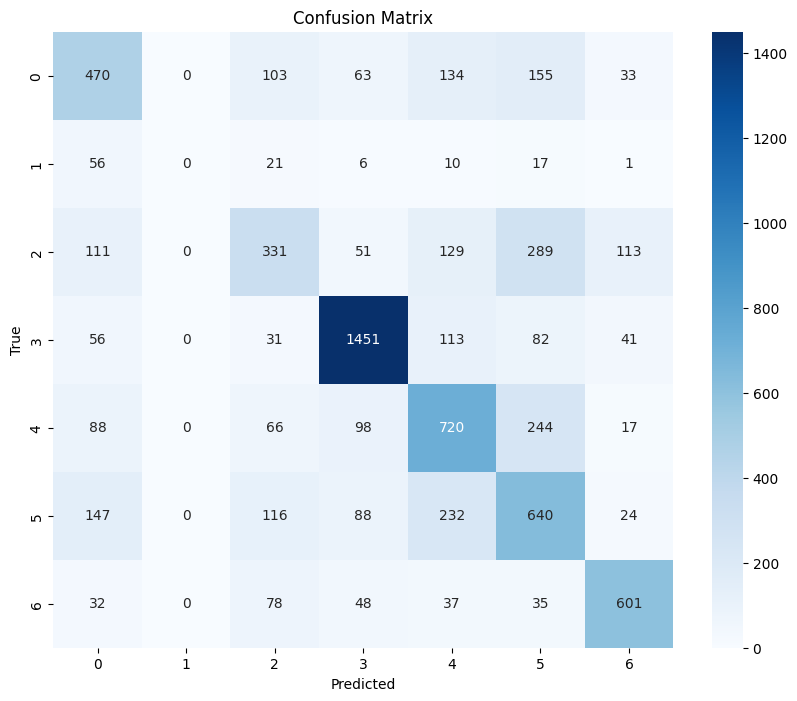

In [13]:
vgg16.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in testLoader:
        images = images.cuda()
        labels = labels.cuda()
        _, outputs = vgg16(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(n_classes), yticklabels=range(n_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### ResNet18

After trying with different transformations we have observed that the model works better with fewer transformations. The reasons have to do with the low resolution of our training data.
* Over-trasformation: can introduce noise and distortions, making it harder for the model to learn relevant features from the images.
* Loss of Information: With low-resolution images, each pixel holds significant information. Transformations such as rotation(with large degrees), shearing, and zooming can lead to the loss of crucial information, which can negatively impact the model's performance.
* Model overfitting: excessive transformations can lead to overfitting if the model learns to recognize the transformations rather than the underlying features of the images.


So we apply some simple transformations:
* Convert it to 1 channel, as the FER2013 dataset contains greyscale images and it is more efficient to work in a single channel.
* Horizontal flipping
* Angle rotation in 5 degrees
* Normalzation

In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score as f1_score_sklearn

# Define the F1 score function
def f1_score(y_true, y_pred):
    epsilon = 1e-7
    y_pred = torch.argmax(y_pred, dim=1)
    tp = torch.sum(y_true * y_pred).float()
    fp = torch.sum(y_pred) - tp
    fn = torch.sum(y_true) - tp
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
    return f1

def calculate_metrics(model, data_loader, criterion, device='cuda'):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    predictions = []
    targets = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect predictions and targets for calculating AUC, precision, recall, and F1 score
            predictions.append(outputs.cpu().numpy())
            targets.append(labels.cpu().numpy())

    # Calculate accuracy and loss
    accuracy = correct / total
    loss = running_loss / len(data_loader.dataset)

    # Convert predictions and targets to numpy arrays
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)

    # Calculate precision, recall, and F1 score
    precision = precision_score(targets, np.argmax(predictions, axis=1), average='macro')
    recall = recall_score(targets, np.argmax(predictions, axis=1), average='macro')
    f1 = f1_score_sklearn(targets, np.argmax(predictions, axis=1), average='macro')

    return accuracy, loss, precision, recall, f1, targets, predictions

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda', patience=5):
    best_val_f1 = 0
    best_model_weights = None
    train_metrics_history = []      #return history
    val_metrics_history = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        f1_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Calculate F1 score
            f1_total += f1_score_sklearn(labels.cpu().detach().numpy(), np.argmax(outputs.cpu().detach().numpy(), axis=1), average='macro')


        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        epoch_f1 = f1_total / len(train_loader)

        # Validation phase
        val_acc, val_loss, val_precision, val_recall, val_f1, targets, predictions = calculate_metrics(model, val_loader, criterion, device)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, F1 Score: {epoch_f1:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1 Score: {val_f1:.4f}')

        train_metrics_history.append((epoch_loss, epoch_acc, epoch_f1))
        val_metrics_history.append((val_loss, val_acc, val_f1))

        # Check if validation F1 score has improved
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_weights = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:                      #if the f1 does not improve, stop, to avoid overfitting
            print('Early stopping')
            break

    # Load best model weights
    model.load_state_dict(best_model_weights)

    return model, train_metrics_history, val_metrics_history

def plot_confusion_matrix(targets, predictions, classes):
    cm = confusion_matrix(targets, np.argmax(predictions, axis=1))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def test_model(model, test_loader, criterion, device='cuda'):
    test_acc, test_loss, test_precision, test_recall, test_f1, targets, predictions = calculate_metrics(model, test_loader, criterion, device)
    test_acc, test_loss, test_precision, test_recall, test_f1
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1 Score: {test_f1:.4f}')

    # Plot confusion matrix for test set
    plot_confusion_matrix(targets, predictions, classes=test_loader.dataset.classes)

    return test_acc, test_loss, test_precision, test_recall, test_f1

In [ ]:
# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the first convolutional layer to accept single-channel (grayscale) input
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Modify the final fully connected layer to match the number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, n_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 200MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Train the model using the train_model function
trained_model, train_metrics_history, val_metrics_history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=60, device=device)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/60, Loss: 1.9245, Accuracy: 0.2333, F1 Score: 0.0937, Val Loss: 1.7896, Val Accuracy: 0.2611, Val Precision: 0.1275, Val Recall: 0.1532, Val F1 Score: 0.0936


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/60, Loss: 1.6911, Accuracy: 0.3179, F1 Score: 0.2043, Val Loss: 2.3191, Val Accuracy: 0.2846, Val Precision: 0.2026, Val Recall: 0.2293, Val F1 Score: 0.1960


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/60, Loss: 1.5804, Accuracy: 0.3769, F1 Score: 0.2762, Val Loss: 1.5712, Val Accuracy: 0.3941, Val Precision: 0.2924, Val Recall: 0.3106, Val F1 Score: 0.2938


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/60, Loss: 1.5018, Accuracy: 0.4095, F1 Score: 0.3166, Val Loss: 1.6223, Val Accuracy: 0.3809, Val Precision: 0.2781, Val Recall: 0.3031, Val F1 Score: 0.2749


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/60, Loss: 1.4737, Accuracy: 0.4215, F1 Score: 0.3296, Val Loss: 1.4751, Val Accuracy: 0.4319, Val Precision: 0.3234, Val Recall: 0.3424, Val F1 Score: 0.3033


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/60, Loss: 1.3845, Accuracy: 0.4631, F1 Score: 0.3786, Val Loss: 1.4250, Val Accuracy: 0.4626, Val Precision: 0.3835, Val Recall: 0.3646, Val F1 Score: 0.3591


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/60, Loss: 1.3233, Accuracy: 0.4908, F1 Score: 0.4107, Val Loss: 1.3830, Val Accuracy: 0.4828, Val Precision: 0.4116, Val Recall: 0.3774, Val F1 Score: 0.3628
Epoch 8/60, Loss: 1.2804, Accuracy: 0.5089, F1 Score: 0.4334, Val Loss: 1.3080, Val Accuracy: 0.4962, Val Precision: 0.4449, Val Recall: 0.4101, Val F1 Score: 0.4082
Epoch 9/60, Loss: 1.2276, Accuracy: 0.5318, F1 Score: 0.4555, Val Loss: 1.2629, Val Accuracy: 0.5165, Val Precision: 0.4310, Val Recall: 0.4268, Val F1 Score: 0.4184
Epoch 10/60, Loss: 1.1824, Accuracy: 0.5510, F1 Score: 0.4822, Val Loss: 1.2370, Val Accuracy: 0.5218, Val Precision: 0.5059, Val Recall: 0.4436, Val F1 Score: 0.4420
Epoch 11/60, Loss: 1.1565, Accuracy: 0.5616, F1 Score: 0.4887, Val Loss: 1.2339, Val Accuracy: 0.5338, Val Precision: 0.5133, Val Recall: 0.4563, Val F1 Score: 0.4364
Epoch 12/60, Loss: 1.1160, Accuracy: 0.5754, F1 Score: 0.5043, Val Loss: 1.1928, Val Accuracy: 0.5455, Val Precision: 0.5500, Val Recall: 0.4557, Val F1 Score: 0.4561
E

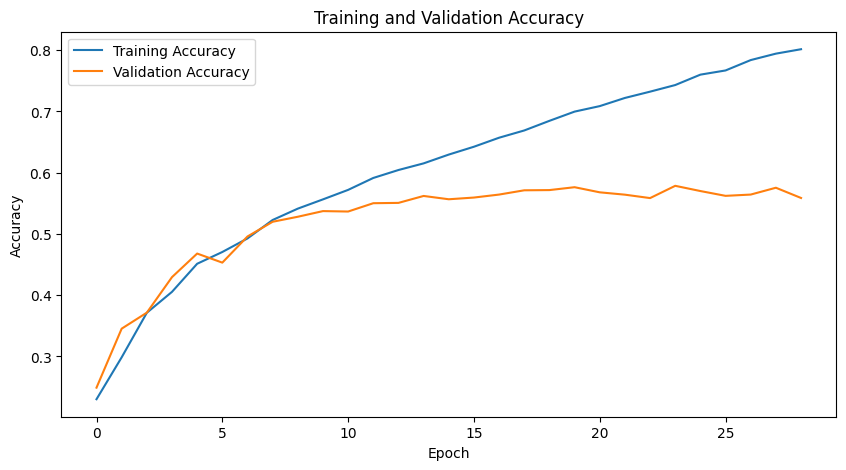

In [ ]:
# Plot training and validation accuracy
train_acc = [x[1] for x in train_metrics_history]
val_acc = [x[1] for x in val_metrics_history]

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

Test Loss: 1.4218, Test Accuracy: 0.5748, Test Precision: 0.5430, Test Recall: 0.5501, Test F1 Score: 0.5452


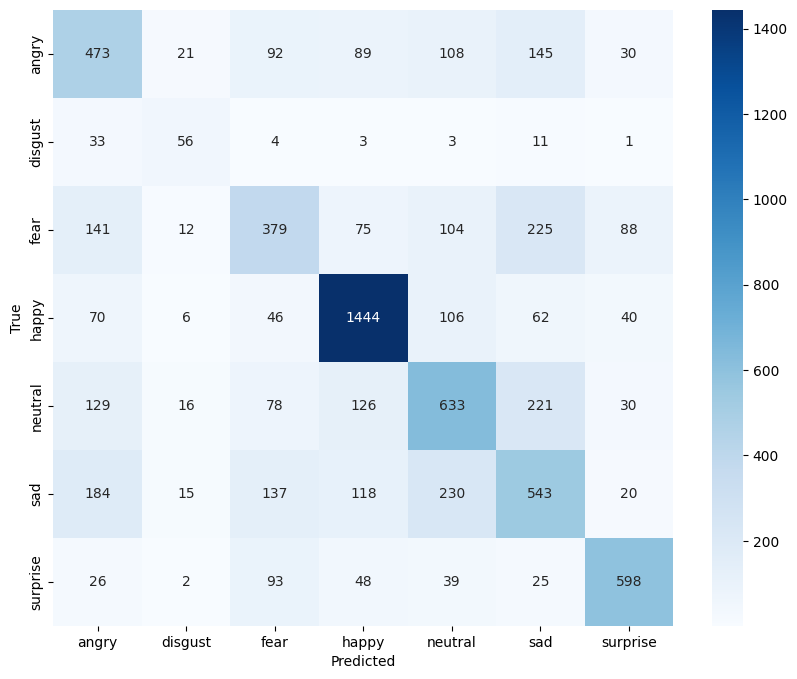

Test Accuracy: 0.5748
Test Loss: 1.4218
Test Precision: 0.5430
Test Recall: 0.5501
Test F1 Score: 0.5452


In [ ]:
test_acc, test_loss, test_precision, test_recall, test_f1 = test_model(trained_model, test_loader,  criterion, device='cuda')

print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

We need to pay attention to the gap between the training and validation F1 scores. A small gap suggests the model is generalizing well. In this case, at the start of the training process it seems it is generalizing correctly, but from the 7th epoch on, there is a great gap between both scores which leads us to think there is overfitting. That is reflected in the gap between the training test accuracy and the validation accuracy too. An early stopping mechanism is implemented in order to stop the learning process when there is no enhancement sign in the process. This helps reducing the risk of overfitting but isn't enough in this case. To avoid that, we can use the weight decay in the optimizer.

In [ ]:
# Load pre-trained ResNet18 model
model2 = models.resnet18(pretrained=True)

# Modify the first convolutional layer to accept single-channel (grayscale) input
model2.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Modify the final fully connected layer to match the number of classes
num_ftrs = model2.fc.in_features
model2.fc = nn.Linear(num_ftrs, n_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 219MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.01, weight_decay=1e-4)          #weigth decai to prevent overfitting

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2.to(device)

# Train the model using the train_model function
trained_model, train_metrics_history, val_metrics_history = train_model(model2, train_loader, val_loader, criterion, optimizer, num_epochs=60, device=device)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/60, Loss: 1.9152, Accuracy: 0.2476, F1 Score: 0.1082, Val Loss: 1.7377, Val Accuracy: 0.3029, Val Precision: 0.1598, Val Recall: 0.2340, Val F1 Score: 0.1717


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/60, Loss: 1.6435, Accuracy: 0.3566, F1 Score: 0.2475, Val Loss: 1.5660, Val Accuracy: 0.3863, Val Precision: 0.2697, Val Recall: 0.2871, Val F1 Score: 0.2534


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/60, Loss: 1.5047, Accuracy: 0.4122, F1 Score: 0.3173, Val Loss: 1.4946, Val Accuracy: 0.4039, Val Precision: 0.3269, Val Recall: 0.3321, Val F1 Score: 0.3249


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/60, Loss: 1.4188, Accuracy: 0.4481, F1 Score: 0.3647, Val Loss: 1.4440, Val Accuracy: 0.4450, Val Precision: 0.3840, Val Recall: 0.3482, Val F1 Score: 0.3456


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/60, Loss: 1.3757, Accuracy: 0.4698, F1 Score: 0.3861, Val Loss: 1.4088, Val Accuracy: 0.4502, Val Precision: 0.3900, Val Recall: 0.3597, Val F1 Score: 0.3546


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/60, Loss: 1.3324, Accuracy: 0.4887, F1 Score: 0.4053, Val Loss: 1.3877, Val Accuracy: 0.4674, Val Precision: 0.4073, Val Recall: 0.3837, Val F1 Score: 0.3754


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/60, Loss: 1.3120, Accuracy: 0.4945, F1 Score: 0.4121, Val Loss: 1.3110, Val Accuracy: 0.4977, Val Precision: 0.4114, Val Recall: 0.4009, Val F1 Score: 0.3939


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/60, Loss: 1.2954, Accuracy: 0.5051, F1 Score: 0.4242, Val Loss: 1.4004, Val Accuracy: 0.4697, Val Precision: 0.3767, Val Recall: 0.3936, Val F1 Score: 0.3723


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/60, Loss: 1.2797, Accuracy: 0.5110, F1 Score: 0.4328, Val Loss: 1.3341, Val Accuracy: 0.4916, Val Precision: 0.4400, Val Recall: 0.3875, Val F1 Score: 0.3877


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/60, Loss: 1.2670, Accuracy: 0.5133, F1 Score: 0.4305, Val Loss: 1.3531, Val Accuracy: 0.4845, Val Precision: 0.3868, Val Recall: 0.4066, Val F1 Score: 0.3809


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/60, Loss: 1.2513, Accuracy: 0.5225, F1 Score: 0.4409, Val Loss: 1.2839, Val Accuracy: 0.5145, Val Precision: 0.4196, Val Recall: 0.4312, Val F1 Score: 0.4189


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/60, Loss: 1.2404, Accuracy: 0.5261, F1 Score: 0.4458, Val Loss: 1.2945, Val Accuracy: 0.5111, Val Precision: 0.4306, Val Recall: 0.4103, Val F1 Score: 0.3898
Epoch 13/60, Loss: 1.2273, Accuracy: 0.5329, F1 Score: 0.4531, Val Loss: 1.2907, Val Accuracy: 0.5071, Val Precision: 0.4753, Val Recall: 0.4264, Val F1 Score: 0.4061
Epoch 14/60, Loss: 1.2192, Accuracy: 0.5352, F1 Score: 0.4570, Val Loss: 1.3046, Val Accuracy: 0.5051, Val Precision: 0.4488, Val Recall: 0.4296, Val F1 Score: 0.4060
Epoch 15/60, Loss: 1.2129, Accuracy: 0.5375, F1 Score: 0.4583, Val Loss: 1.2775, Val Accuracy: 0.5197, Val Precision: 0.5380, Val Recall: 0.4470, Val F1 Score: 0.4533
Epoch 16/60, Loss: 1.2064, Accuracy: 0.5377, F1 Score: 0.4597, Val Loss: 1.2762, Val Accuracy: 0.5235, Val Precision: 0.5080, Val Recall: 0.4364, Val F1 Score: 0.4450
Epoch 17/60, Loss: 1.1999, Accuracy: 0.5425, F1 Score: 0.4686, Val Loss: 1.2184, Val Accuracy: 0.5434, Val Precision: 0.5972, Val Recall: 0.4546, Val F1 Score: 0.442

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 21/60, Loss: 1.1841, Accuracy: 0.5501, F1 Score: 0.4760, Val Loss: 1.2752, Val Accuracy: 0.5209, Val Precision: 0.4257, Val Recall: 0.4345, Val F1 Score: 0.4132
Epoch 22/60, Loss: 1.1774, Accuracy: 0.5487, F1 Score: 0.4699, Val Loss: 1.2569, Val Accuracy: 0.5373, Val Precision: 0.4953, Val Recall: 0.4507, Val F1 Score: 0.4473
Epoch 23/60, Loss: 1.1708, Accuracy: 0.5543, F1 Score: 0.4781, Val Loss: 1.2649, Val Accuracy: 0.5226, Val Precision: 0.4668, Val Recall: 0.4598, Val F1 Score: 0.4493
Epoch 24/60, Loss: 1.1667, Accuracy: 0.5561, F1 Score: 0.4768, Val Loss: 1.2792, Val Accuracy: 0.5108, Val Precision: 0.4822, Val Recall: 0.4377, Val F1 Score: 0.4207
Epoch 25/60, Loss: 1.1630, Accuracy: 0.5578, F1 Score: 0.4873, Val Loss: 1.2139, Val Accuracy: 0.5390, Val Precision: 0.4843, Val Recall: 0.4559, Val F1 Score: 0.4501
Early stopping


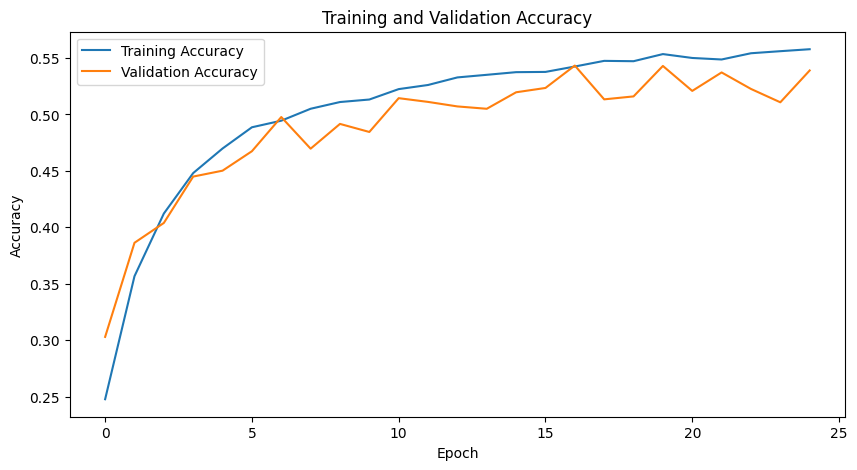

In [ ]:
# Plot training and validation accuracy
train_acc = [x[1] for x in train_metrics_history]
val_acc = [x[1] for x in val_metrics_history]

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

Test Loss: 1.2136, Test Accuracy: 0.5398, Test Precision: 0.5254, Test Recall: 0.4671, Test F1 Score: 0.4686


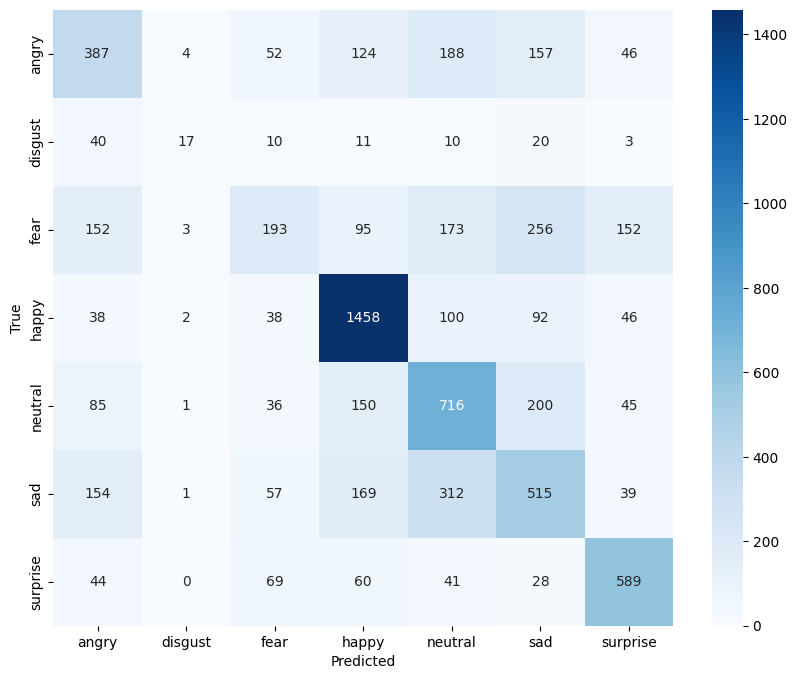

Test Accuracy: 0.5398
Test Loss: 1.2136
Test Precision: 0.5254
Test Recall: 0.4671
Test F1 Score: 0.4686


In [ ]:
test_acc, test_loss, test_precision, test_recall, test_f1 = test_model(trained_model, test_loader,  criterion, device='cuda')

print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

#### SDG Optimizator

In [ ]:
# Load pre-trained ResNet18 model
model3 = models.resnet18(pretrained=True)

# Modify the first convolutional layer to accept single-channel (grayscale) input
model3.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Modify the final fully connected layer to match the number of classes
num_ftrs = model3.fc.in_features
model3.fc = nn.Linear(num_ftrs, n_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 218MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)       #changed to SGD

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model3.to(device)

# Train the model using the train_model function
trained_model, train_metrics_history, val_metrics_history = train_model(model3, train_loader, val_loader, criterion, optimizer, num_epochs=60, device=device)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/60, Loss: 1.9044, Accuracy: 0.2739, F1 Score: 0.1661, Val Loss: 1.6395, Val Accuracy: 0.3619, Val Precision: 0.2472, Val Recall: 0.2954, Val F1 Score: 0.2464


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/60, Loss: 1.5677, Accuracy: 0.3885, F1 Score: 0.2866, Val Loss: 1.4981, Val Accuracy: 0.4117, Val Precision: 0.4399, Val Recall: 0.3355, Val F1 Score: 0.3088


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/60, Loss: 1.4187, Accuracy: 0.4508, F1 Score: 0.3671, Val Loss: 1.4267, Val Accuracy: 0.4596, Val Precision: 0.4207, Val Recall: 0.3686, Val F1 Score: 0.3518
Epoch 4/60, Loss: 1.3138, Accuracy: 0.4998, F1 Score: 0.4197, Val Loss: 1.3310, Val Accuracy: 0.4967, Val Precision: 0.4970, Val Recall: 0.4221, Val F1 Score: 0.3959
Epoch 5/60, Loss: 1.2530, Accuracy: 0.5241, F1 Score: 0.4497, Val Loss: 1.2886, Val Accuracy: 0.5150, Val Precision: 0.4683, Val Recall: 0.4414, Val F1 Score: 0.4377
Epoch 6/60, Loss: 1.1759, Accuracy: 0.5552, F1 Score: 0.4843, Val Loss: 1.2990, Val Accuracy: 0.5211, Val Precision: 0.5044, Val Recall: 0.4545, Val F1 Score: 0.4666
Epoch 7/60, Loss: 1.1331, Accuracy: 0.5685, F1 Score: 0.5014, Val Loss: 1.2542, Val Accuracy: 0.5366, Val Precision: 0.5470, Val Recall: 0.4657, Val F1 Score: 0.4737
Epoch 8/60, Loss: 1.0966, Accuracy: 0.5881, F1 Score: 0.5263, Val Loss: 1.2409, Val Accuracy: 0.5430, Val Precision: 0.5241, Val Recall: 0.4804, Val F1 Score: 0.4836
Epoc

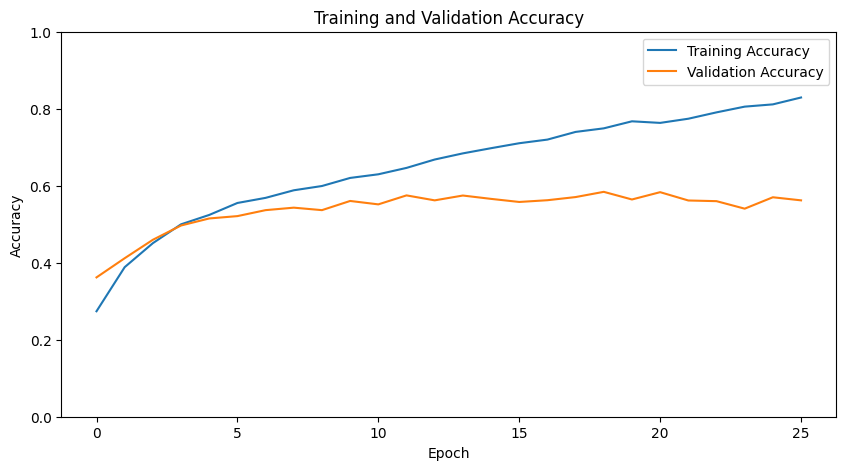

In [ ]:
# Plot training and validation accuracy
train_acc = [x[1] for x in train_metrics_history]
val_acc = [x[1] for x in val_metrics_history]

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.ylim(0, 1)  # Set the y-axis scale from 0 to 1
plt.show()

Test Loss: 1.4761, Test Accuracy: 0.5752, Test Precision: 0.5754, Test Recall: 0.5354, Test F1 Score: 0.5487


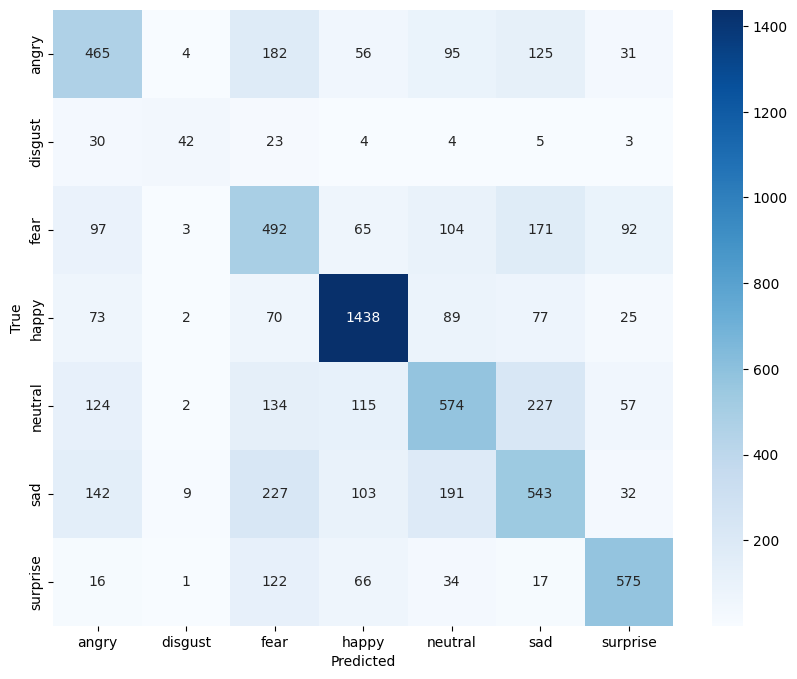

Test Accuracy: 0.5752
Test Loss: 1.4761
Test Precision: 0.5754
Test Recall: 0.5354
Test F1 Score: 0.5487


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

test_acc, test_loss, test_precision, test_recall, test_f1 = test_model(trained_model, test_loader,  criterion, device='cuda')

print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

### ResNet50:

In [ ]:
# Load pre-trained ResNet18 model
model = models.resnet50(pretrained=True)

# Modify the first convolutional layer to accept single-channel (grayscale) input
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Modify the final fully connected layer to match the number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, n_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)          #weigth decai to prevent overfitting

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Train the model using the train_model function
trained_model, train_metrics_history, val_metrics_history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=60, device=device)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/60, Loss: 1.9108, Accuracy: 0.2454, F1 Score: 0.0823, Val Loss: 2.3221, Val Accuracy: 0.2626, Val Precision: 0.1598, Val Recall: 0.1669, Val F1 Score: 0.1098


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/60, Loss: 1.7027, Accuracy: 0.3138, F1 Score: 0.1869, Val Loss: 2.7473, Val Accuracy: 0.2922, Val Precision: 0.1530, Val Recall: 0.1987, Val F1 Score: 0.1526


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/60, Loss: 1.5787, Accuracy: 0.3771, F1 Score: 0.2765, Val Loss: 1.5900, Val Accuracy: 0.3739, Val Precision: 0.2968, Val Recall: 0.2806, Val F1 Score: 0.2632


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/60, Loss: 1.5040, Accuracy: 0.4152, F1 Score: 0.3246, Val Loss: 1.5119, Val Accuracy: 0.4169, Val Precision: 0.3324, Val Recall: 0.3225, Val F1 Score: 0.3033


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/60, Loss: 1.4675, Accuracy: 0.4280, F1 Score: 0.3428, Val Loss: 1.4815, Val Accuracy: 0.4155, Val Precision: 0.3356, Val Recall: 0.3250, Val F1 Score: 0.3214


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/60, Loss: 1.4346, Accuracy: 0.4446, F1 Score: 0.3628, Val Loss: 1.5162, Val Accuracy: 0.3986, Val Precision: 0.3382, Val Recall: 0.3305, Val F1 Score: 0.3093


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/60, Loss: 1.4044, Accuracy: 0.4574, F1 Score: 0.3729, Val Loss: 1.4631, Val Accuracy: 0.4361, Val Precision: 0.3361, Val Recall: 0.3575, Val F1 Score: 0.3346


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/60, Loss: 1.3831, Accuracy: 0.4625, F1 Score: 0.3771, Val Loss: 1.3996, Val Accuracy: 0.4598, Val Precision: 0.3637, Val Recall: 0.3757, Val F1 Score: 0.3633


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/60, Loss: 1.3591, Accuracy: 0.4748, F1 Score: 0.3901, Val Loss: 1.4016, Val Accuracy: 0.4509, Val Precision: 0.3892, Val Recall: 0.3592, Val F1 Score: 0.3369


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/60, Loss: 1.3482, Accuracy: 0.4796, F1 Score: 0.3934, Val Loss: 1.4635, Val Accuracy: 0.4349, Val Precision: 0.3577, Val Recall: 0.3428, Val F1 Score: 0.3184


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/60, Loss: 1.3333, Accuracy: 0.4835, F1 Score: 0.4016, Val Loss: 1.4082, Val Accuracy: 0.4603, Val Precision: 0.3808, Val Recall: 0.3667, Val F1 Score: 0.3488


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/60, Loss: 1.3226, Accuracy: 0.4921, F1 Score: 0.4089, Val Loss: 1.3246, Val Accuracy: 0.4932, Val Precision: 0.3927, Val Recall: 0.4046, Val F1 Score: 0.3844
Epoch 13/60, Loss: 1.3110, Accuracy: 0.4933, F1 Score: 0.4093, Val Loss: 1.3234, Val Accuracy: 0.4876, Val Precision: 0.4070, Val Recall: 0.4088, Val F1 Score: 0.4068


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/60, Loss: 1.3023, Accuracy: 0.4973, F1 Score: 0.4129, Val Loss: 1.3078, Val Accuracy: 0.4934, Val Precision: 0.3989, Val Recall: 0.4022, Val F1 Score: 0.3905


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15/60, Loss: 1.2930, Accuracy: 0.5036, F1 Score: 0.4191, Val Loss: 1.3839, Val Accuracy: 0.4678, Val Precision: 0.3699, Val Recall: 0.3848, Val F1 Score: 0.3561


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16/60, Loss: 1.2878, Accuracy: 0.5027, F1 Score: 0.4184, Val Loss: 1.3368, Val Accuracy: 0.4930, Val Precision: 0.3950, Val Recall: 0.3962, Val F1 Score: 0.3835


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17/60, Loss: 1.2825, Accuracy: 0.5051, F1 Score: 0.4234, Val Loss: 1.2904, Val Accuracy: 0.5124, Val Precision: 0.4215, Val Recall: 0.4127, Val F1 Score: 0.3969
Epoch 18/60, Loss: 1.2695, Accuracy: 0.5151, F1 Score: 0.4295, Val Loss: 1.3124, Val Accuracy: 0.5017, Val Precision: 0.4041, Val Recall: 0.4077, Val F1 Score: 0.3977
Early stopping


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


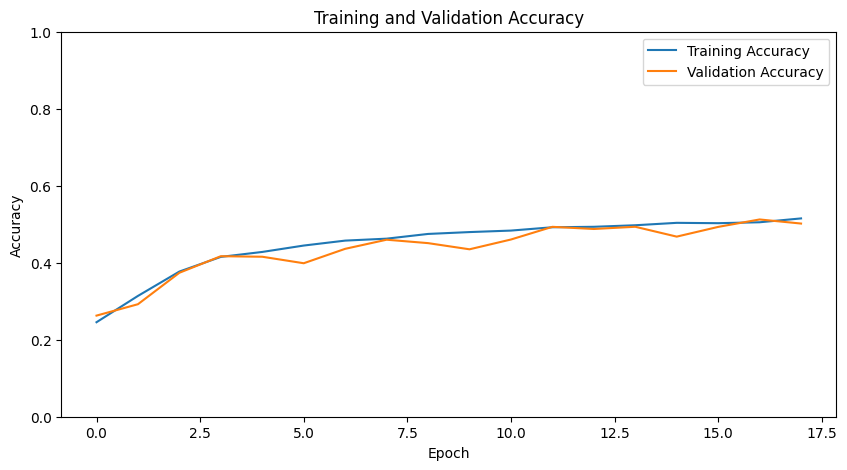

In [ ]:
# Plot training and validation accuracy
train_acc = [x[1] for x in train_metrics_history]
val_acc = [x[1] for x in val_metrics_history]

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.ylim(0, 1)  # Set the y-axis scale from 0 to 1
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 1.3210, Test Accuracy: 0.4947, Test Precision: 0.4014, Test Recall: 0.4033, Test F1 Score: 0.3944


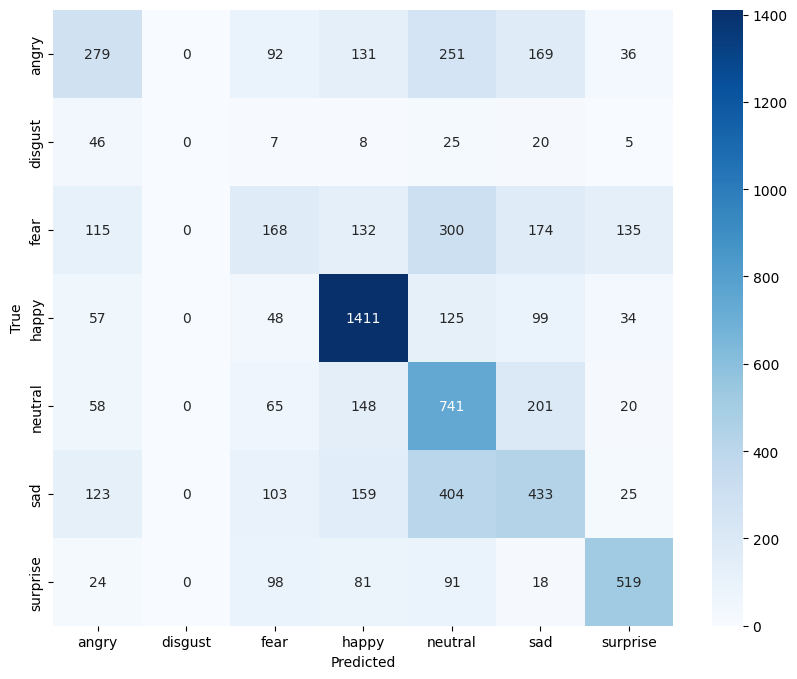

Test Accuracy: 0.4947
Test Loss: 1.3210
Test Precision: 0.4014
Test Recall: 0.4033
Test F1 Score: 0.3944


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

test_acc, test_loss, test_precision, test_recall, test_f1 = test_model(trained_model, test_loader,  criterion, device='cuda')

print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

### MobileNet

In [ ]:

img_width, img_height = 48, 48
batch_size = 64

no_of_classes = 7

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Usar el 20% de los datos para validación
)

train_generator = train_datagen.flow_from_directory(
    '/content/train/train',
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/train/train',
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Subconjunto de datos para validación
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D, Dropout
from tensorflow.keras.regularizers import l2

mobilenet_base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

mobilenet_model = tf.keras.models.Sequential()
mobilenet_model.add(mobilenet_base_model)
mobilenet_model.add(GlobalMaxPooling2D())
mobilenet_model.add(Dense(20, activation='relu', kernel_regularizer=l2(0.07)))
mobilenet_model.add(Dropout(0.6))
mobilenet_model.add(Dense(20, activation='relu', kernel_regularizer=l2(0.07)))
mobilenet_model.add(Dense(7, activation='softmax'))
mobilenet_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 1, 1, 1024)        3228864   
 onal)                                                           
                                                                 
 global_max_pooling2d_1 (Gl  (None, 1024)              0         
 obalMaxPooling2D)                                               
                                                                 
 dense_3 (Dense)             (None, 20)                20500     
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 7)                

In [ ]:
mobilenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
mobilenet_history = mobilenet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20
)

Epoch 1/20
359/359 [==============================] - 35s 63ms/step - loss: 2.8923 - accuracy: 0.2989 - val_loss: 1.6887 - val_accuracy: 0.4435
Epoch 2/20
359/359 [==============================] - 24s 66ms/step - loss: 1.5500 - accuracy: 0.4510 - val_loss: 1.3735 - val_accuracy: 0.5107
Epoch 3/20
359/359 [==============================] - 21s 60ms/step - loss: 1.3995 - accuracy: 0.4868 - val_loss: 1.3750 - val_accuracy: 0.5248
Epoch 4/20
359/359 [==============================] - 23s 65ms/step - loss: 1.3292 - accuracy: 0.5228 - val_loss: 1.3301 - val_accuracy: 0.5318
Epoch 5/20
359/359 [==============================] - 22s 62ms/step - loss: 1.2836 - accuracy: 0.5392 - val_loss: 1.3306 - val_accuracy: 0.5259
Epoch 6/20
359/359 [==============================] - 24s 68ms/step - loss: 1.2483 - accuracy: 0.5566 - val_loss: 1.3664 - val_accuracy: 0.5090
Epoch 7/20
359/359 [==============================] - 24s 67ms/step - loss: 1.2148 - accuracy: 0.5685 - val_loss: 1.3771 - val_accuracy:

In [ ]:

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/test/test',
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

mobilenet_test_loss, mobilenet_test_accuracy = mobilenet_model.evaluate(test_generator)

print(f"Test Loss: {mobilenet_test_loss}")
print(f"Test Accuracy: {mobilenet_test_accuracy}")

Found 7178 images belonging to 7 classes.
113/113 [==============================] - 4s 38ms/step - loss: 1.4237 - accuracy: 0.5666
Test Loss: 1.423735499382019
Test Accuracy: 0.5665923953056335


In [ ]:
predictions = mobilenet_model.predict(test_generator)

true_classes = test_generator.classes

# Convertir las predicciones de probabilidad en clases predichas
predicted_classes = np.argmax(predictions, axis=1)

# Calcular la matriz de confusión
confusion_matrix_result = confusion_matrix(true_classes, predicted_classes)

113/113 [==============================] - 4s 28ms/step


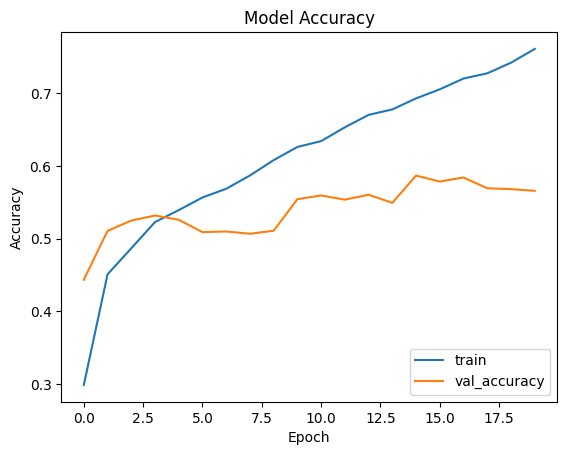

In [ ]:
plt.plot(mobilenet_history.history['accuracy'])
plt.plot(mobilenet_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val_accuracy'], loc='lower right')
plt.show()


In [ ]:
def test_model(model,class_names):
    prefix = "/content/test/test"

    classes = os.listdir(prefix)

    choices = []

    for i in range(6):
        temp = {}
        for j in range(5):
            ch = random.choice(classes)
            li = os.listdir(prefix+"/"+ch)
            file_ = prefix+"/"+ch+"/"+random.choice(li)
            temp[file_] = ch
        choices.append(temp)


    plt.figure(figsize=(20, 20))
    n = 4
    im = 8
    ct = 1
    for row in choices:
        for i in row:
            ax = plt.subplot(im, n, ct)
            ct = ct + 1
            image =  cv2.imread(i)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.imshow(image)
            image = np.expand_dims(image, 0)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_title("True: {}, Predicted:{}".format(row[i], class_names[np.argmax(model.predict(image)[0])]))
    plt.show()


1/1 [==============================] - 0s 20ms/step


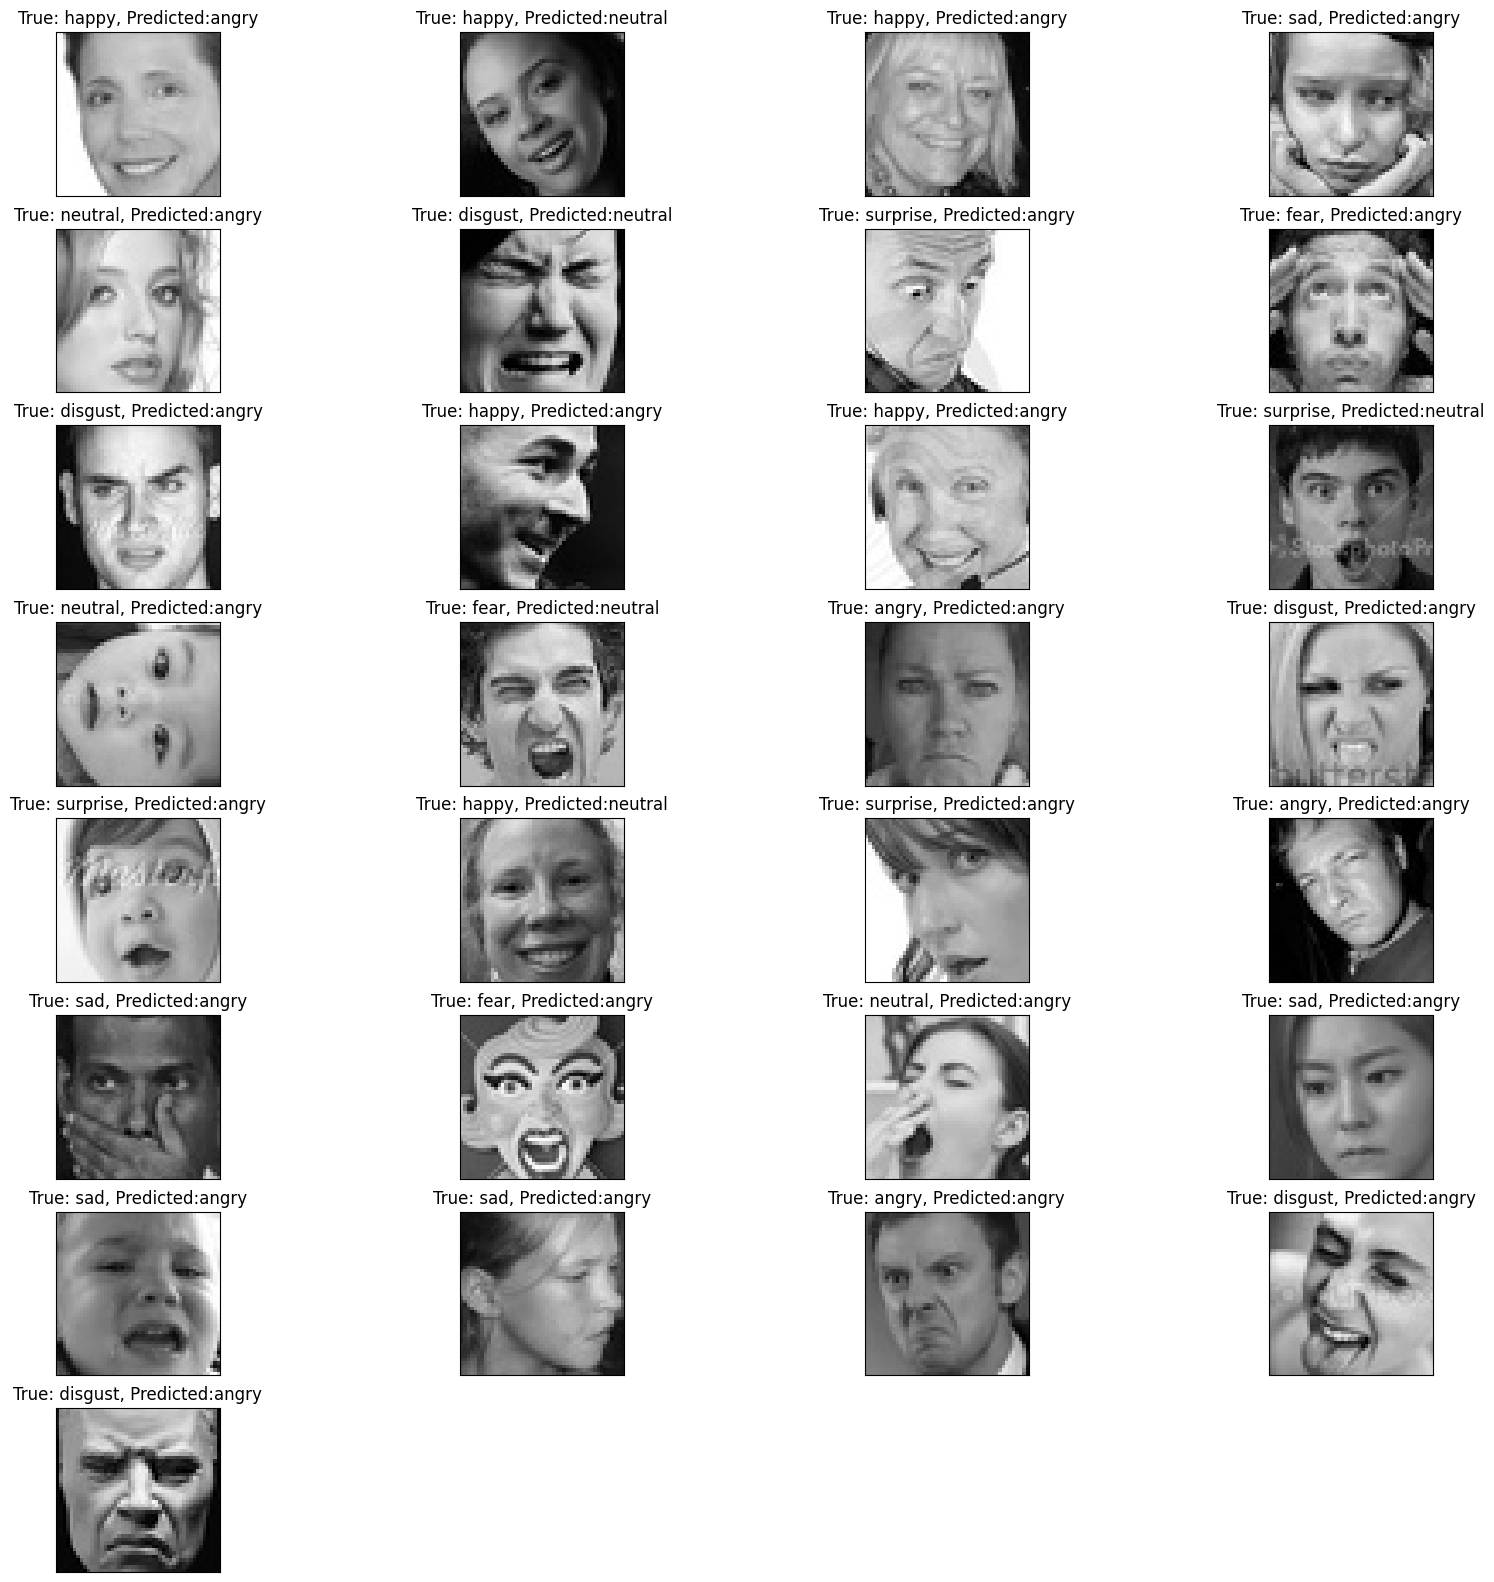

In [ ]:
test_model(mobilenet_model,test_dataset.classes)

### Efficent Net (another)

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

from tensorflow.keras.layers import Dropout

efficientnet_base_model1 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

x = efficientnet_base_model1.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

# Unfreeze some layers
for layer in efficientnet_base_model1.layers[-20:]:
    layer.trainable = True

efficientnet_model1 = Model(inputs=efficientnet_base_model1.input, outputs=predictions)


efficientnet_model1.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)

# Training the model
efficientnet_history1 = efficientnet_model1.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
359/359 [==============================] - 94s 136ms/step - loss: 4.1708 - accuracy: 0.1988 - val_loss: 3.9934 - val_accuracy: 0.2250 - lr: 1.0000e-05
Epoch 2/20
359/359 [==============================] - 49s 136ms/step - loss: 4.0688 - accuracy: 0.2164 - val_loss: 3.9631 - val_accuracy: 0.2062 - lr: 1.0000e-05
Epoch 3/20
359/359 [==============================] - 48s 133ms/step - loss: 4.0093 - accuracy: 0.2356 - val_loss: 3.9658 - val_accuracy: 0.1968 - lr: 1.0000e-05
Epoch 4/20
359/359 [==============================] - 47s 132ms/step - loss: 3.9525 - accuracy: 0.2550 - val_loss: 3.8925 - val_accuracy: 0.2632 - lr: 1.0000e-05
Epoch 5/20
359/359 [==============================] - 46s 128ms/step - loss: 3.9035 - accuracy: 0.2722 - val_loss: 3.8658 - val_accuracy: 0.2712 - lr: 1.0000e-05
Epoch 6/20
359/359 [==============================] - 47s 131ms/step - loss: 3.8580 - accuracy: 0.2817 - val_loss: 3.8315 - val_accuracy: 0.2773 - lr: 1.0000e-05
Epoch 7/20
359/359 [========

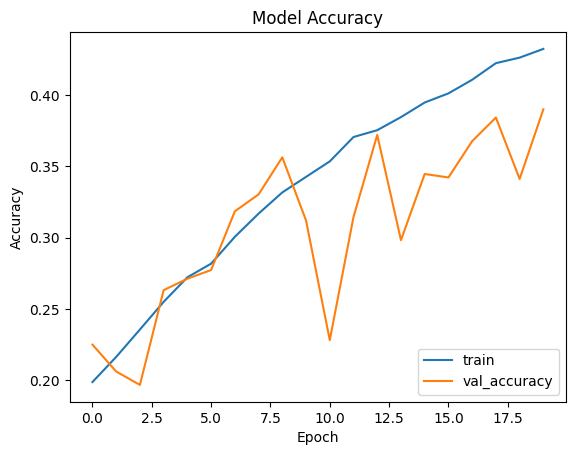

In [ ]:
plt.plot(efficientnet_history1.history['accuracy'])
plt.plot(efficientnet_history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val_accuracy'], loc='lower right')
plt.show()

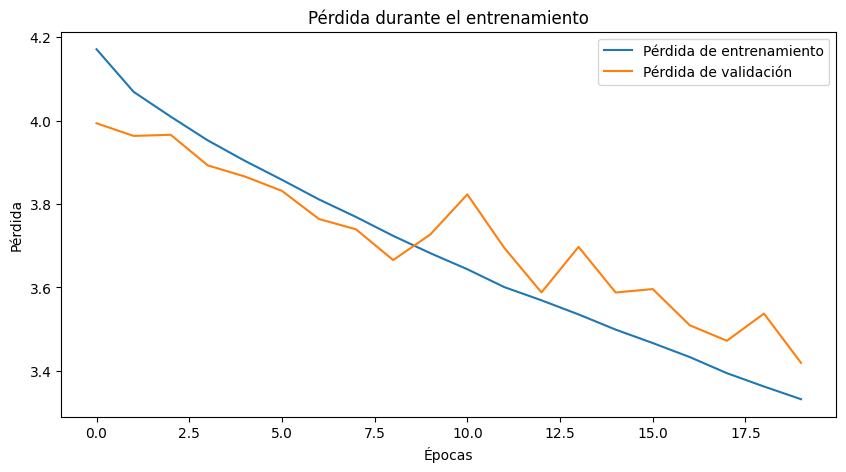

In [ ]:
train_loss = efficientnet_history1.history['loss']
val_loss = efficientnet_history1.history['val_loss']
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Pérdida de entrenamiento')
plt.plot(val_loss, label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


In [ ]:
eficient1_test_loss,eficient1_test_accuracy = efficientnet_model1.evaluate(test_generator)


113/113 [==============================] - 4s 33ms/step - loss: 3.3919 - accuracy: 0.4082


In [ ]:
print(f"Test Loss: {eficient1_test_loss}")
print(f"Test Accuracy: {eficient1_test_accuracy}")

Test Loss: 3.391925573348999
Test Accuracy: 0.4081917107105255


1/1 [==============================] - 0s 30ms/step


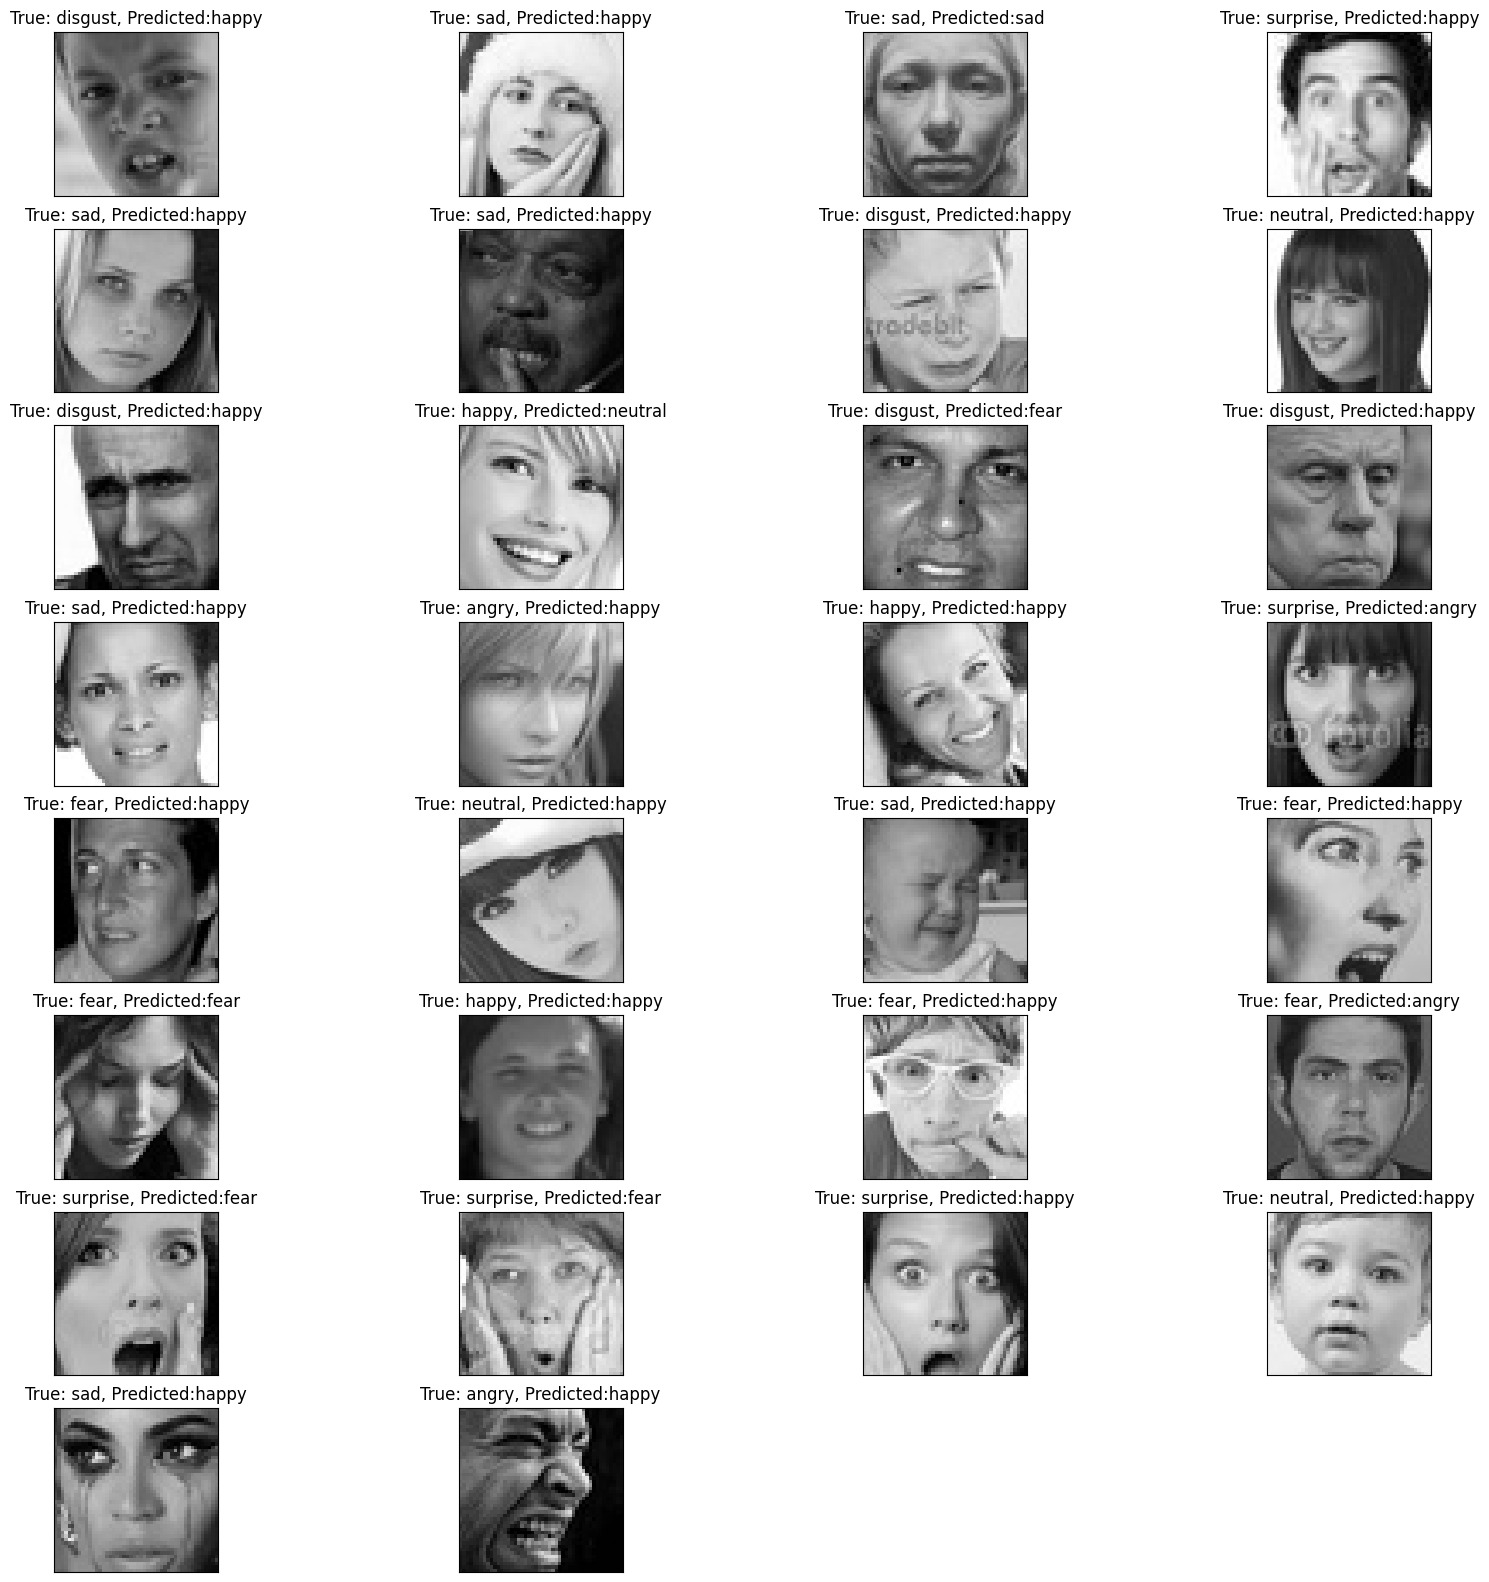

In [ ]:
test_model(efficientnet_model1,test_dataset.classes)

### CNN

In [ ]:
cnn_model = Sequential()

cnn_model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 3)))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(128, (3, 3), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(256, (3, 3), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(512, (3, 3), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(512, (3, 3), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())
cnn_model.add(Dense(512))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(512))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(7, activation='softmax'))

optimizer = Adam(learning_rate=0.001)


cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


#cnn_model.summary()

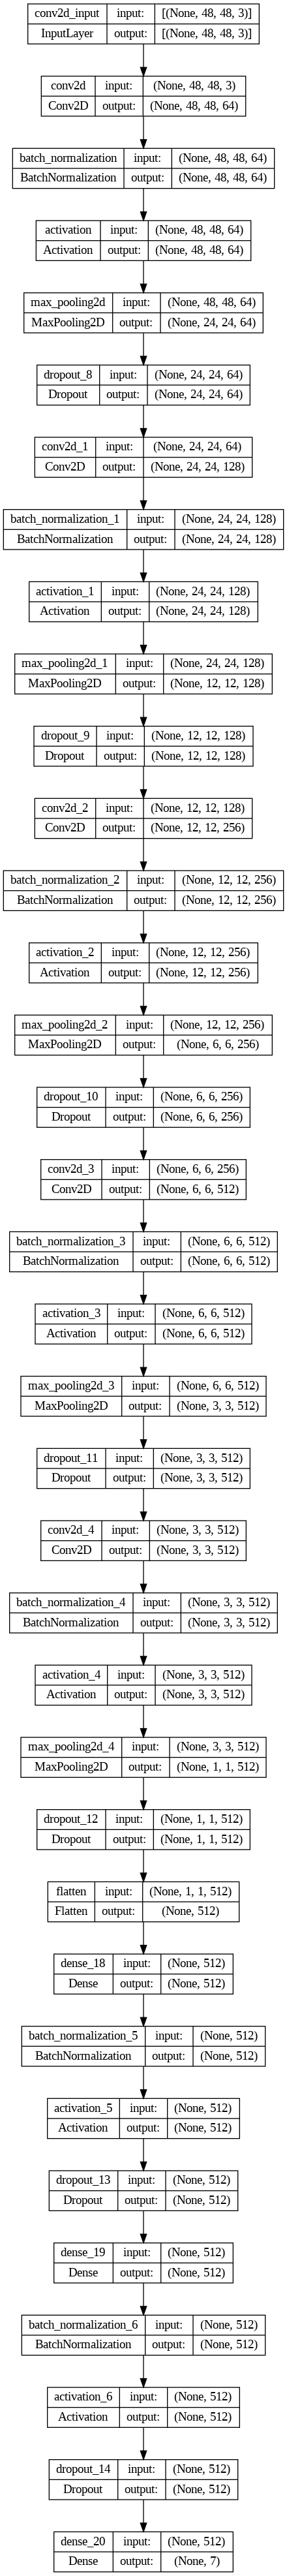

In [ ]:
plot_model(cnn_model, to_file='cnn_model_diagram.png', show_shapes=True, show_layer_names = True)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001)



In [ ]:

img_width, img_height = 48, 48
batch_size = 64

no_of_classes = 7

In [ ]:
cnn_history = cnn_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/20
359/359 [==============================] - 43s 86ms/step - loss: 2.0231 - accuracy: 0.2358 - val_loss: 2.0263 - val_accuracy: 0.2513
Epoch 2/20
359/359 [==============================] - 22s 62ms/step - loss: 1.6226 - accuracy: 0.3721 - val_loss: 1.5618 - val_accuracy: 0.4200
Epoch 3/20
359/359 [==============================] - 19s 54ms/step - loss: 1.4249 - accuracy: 0.4499 - val_loss: 1.4658 - val_accuracy: 0.4398
Epoch 4/20
359/359 [==============================] - 24s 66ms/step - loss: 1.3127 - accuracy: 0.4990 - val_loss: 1.4066 - val_accuracy: 0.4701
Epoch 5/20
359/359 [==============================] - 23s 63ms/step - loss: 1.2451 - accuracy: 0.5283 - val_loss: 1.3197 - val_accuracy: 0.4877
Epoch 6/20
359/359 [==============================] - 23s 63ms/step - loss: 1.1968 - accuracy: 0.5454 - val_loss: 1.1923 - val_accuracy: 0.5316
Epoch 7/20
359/359 [==============================] - 20s 54ms/step - loss: 1.1506 - accuracy: 0.5654 - val_loss: 1.2582 - val_accuracy:

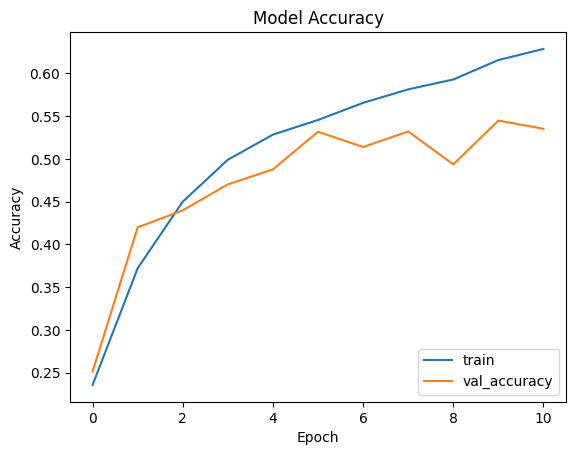

In [ ]:
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val_accuracy'], loc='lower right')
plt.show()

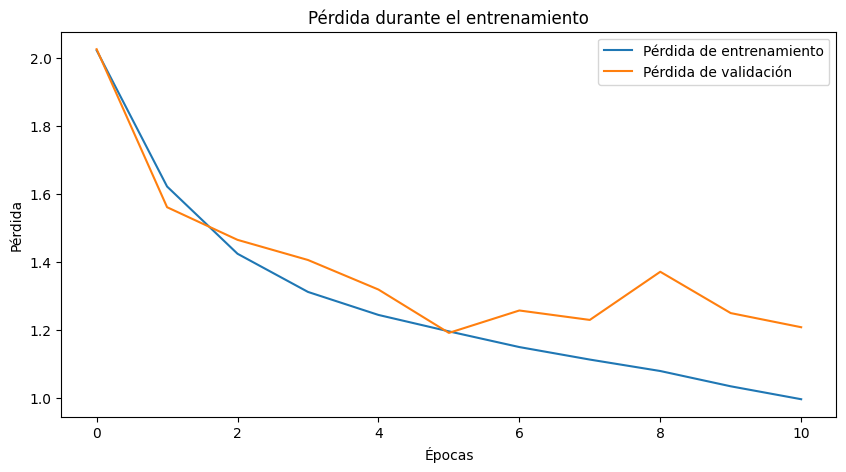

In [ ]:
train_loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Pérdida de entrenamiento')
plt.plot(val_loss, label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


In [ ]:
test_generator = test_datagen.flow_from_directory(
     "/content/test/test",
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical'
)
test_loss, test_accuracy = cnn_model.evaluate(test_generator)


Found 7178 images belonging to 7 classes.
113/113 [==============================] - 5s 43ms/step - loss: 1.1718 - accuracy: 0.5447


In [ ]:
print(test_loss, test_accuracy )

1.1718175411224365 0.5447199940681458


1/1 [==============================] - 0s 28ms/step


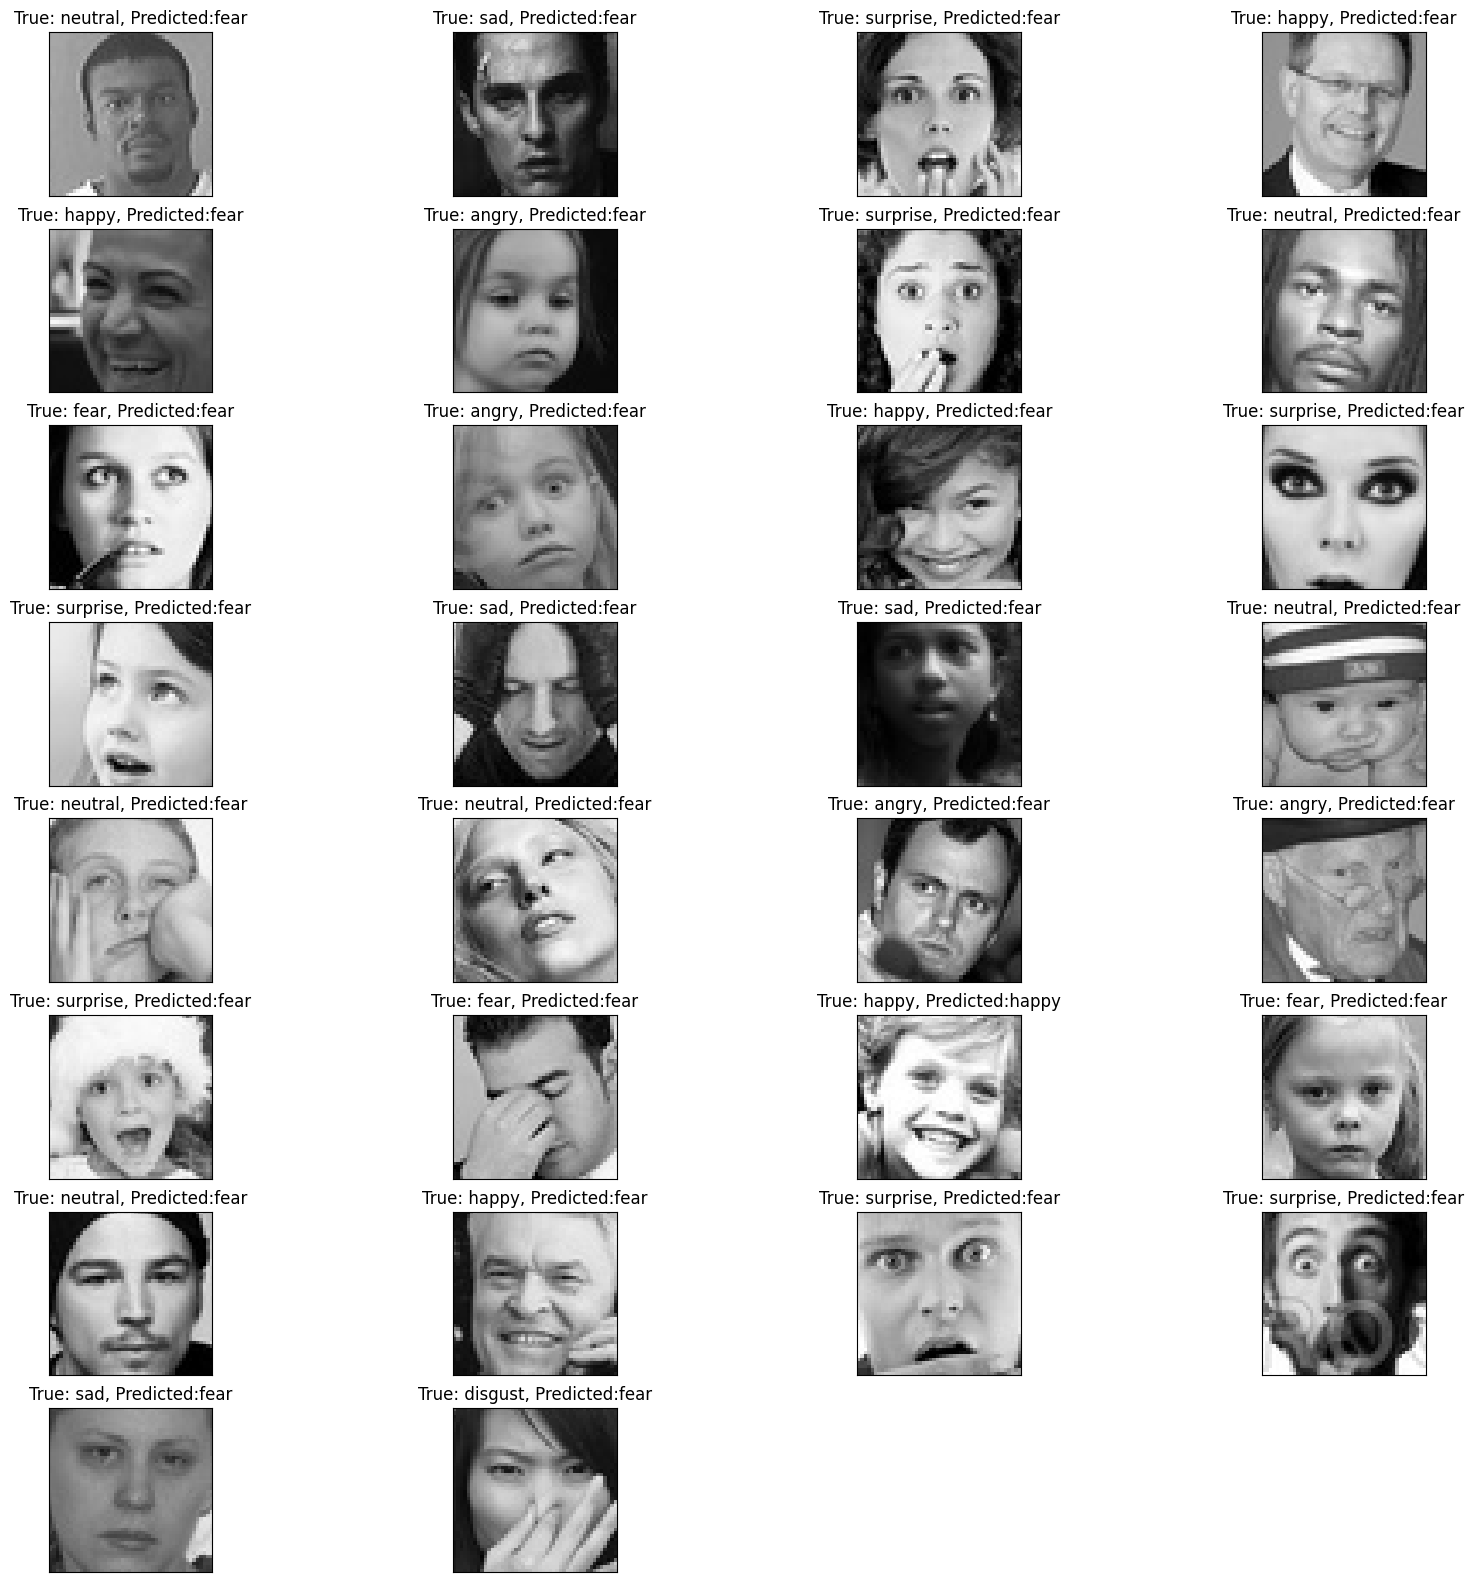

In [ ]:
test_model(cnn_model,test_dataset.classes)

### CNN2

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense

model = Sequential([
    Conv2D(10, (5, 5), activation='relu', input_shape=(48, 48, 3)),
    Conv2D(10, (5, 5), activation='relu'),
    Conv2D(10, (1, 1), activation='relu'),
    MaxPooling2D((3, 3)),
    BatchNormalization(),

    Conv2D(40, (1, 1), activation='relu'),
    Conv2D(40, (1, 1), activation='relu'),
    MaxPooling2D((3, 3)),
    BatchNormalization(),

    Conv2D(80, (1, 1), activation='relu'),
    Conv2D(80, (1, 1), activation='relu'),
    MaxPooling2D((3, 3)),
    BatchNormalization(),

    Conv2D(80, (1, 1), activation='relu'),
    Flatten(),

    Dense(80, activation='relu'),
    Dense(30, activation='relu'),
    Dense(7, activation='softmax')
])



model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy',metrics=['accuracy'])






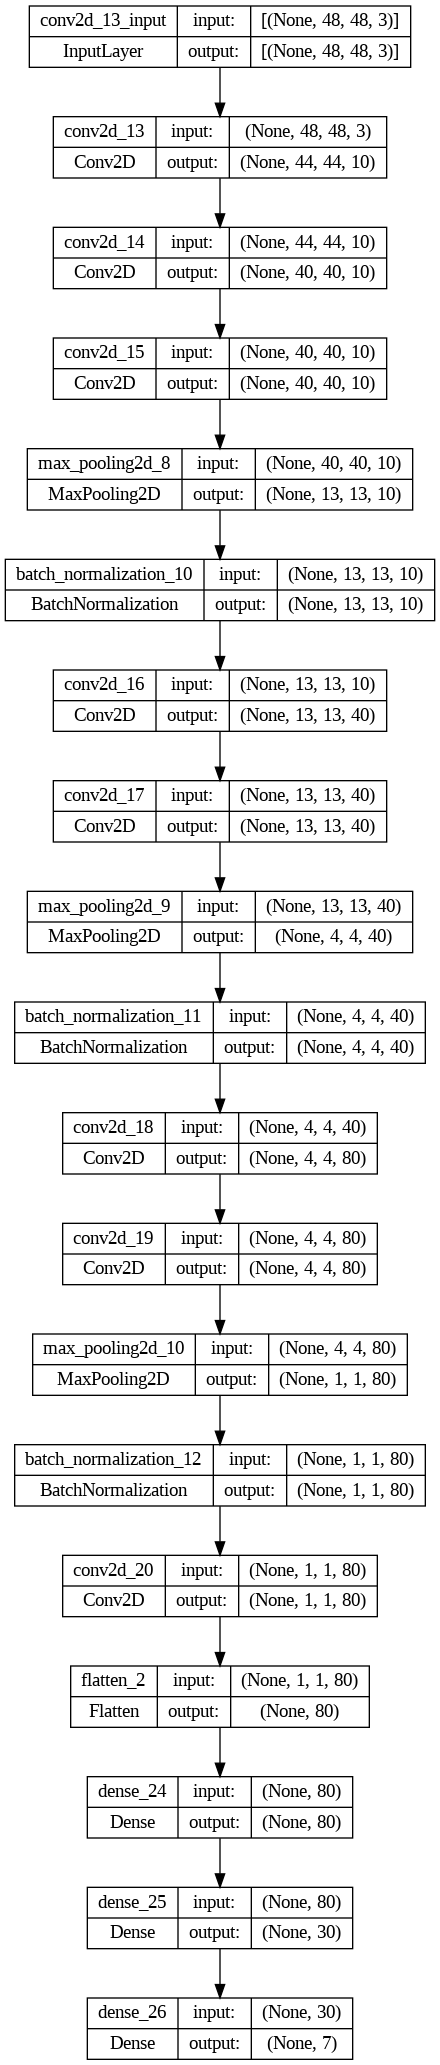

In [ ]:
plot_model(model, to_file='cnn2_model_diagram.png', show_shapes=True, show_layer_names = True)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001)



In [ ]:

img_width, img_height = 48, 48
batch_size = 64

no_of_classes = 7

In [ ]:
cnn_history2 = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/20
359/359 [==============================] - 28s 60ms/step - loss: 1.8272 - accuracy: 0.2179 - val_loss: 1.8274 - val_accuracy: 0.2515
Epoch 2/20
359/359 [==============================] - 14s 38ms/step - loss: 1.7830 - accuracy: 0.2483 - val_loss: 1.7979 - val_accuracy: 0.2541
Epoch 3/20
359/359 [==============================] - 14s 38ms/step - loss: 1.7686 - accuracy: 0.2627 - val_loss: 1.7876 - val_accuracy: 0.2567
Epoch 4/20
359/359 [==============================] - 13s 37ms/step - loss: 1.7560 - accuracy: 0.2749 - val_loss: 1.7685 - val_accuracy: 0.2594
Epoch 5/20
359/359 [==============================] - 14s 38ms/step - loss: 1.7439 - accuracy: 0.2813 - val_loss: 1.7670 - val_accuracy: 0.2721
Epoch 6/20
359/359 [==============================] - 13s 37ms/step - loss: 1.7347 - accuracy: 0.2856 - val_loss: 1.7552 - val_accuracy: 0.2749
Epoch 7/20
359/359 [==============================] - 14s 39ms/step - loss: 1.7225 - accuracy: 0.2923 - val_loss: 1.7497 - val_accuracy:

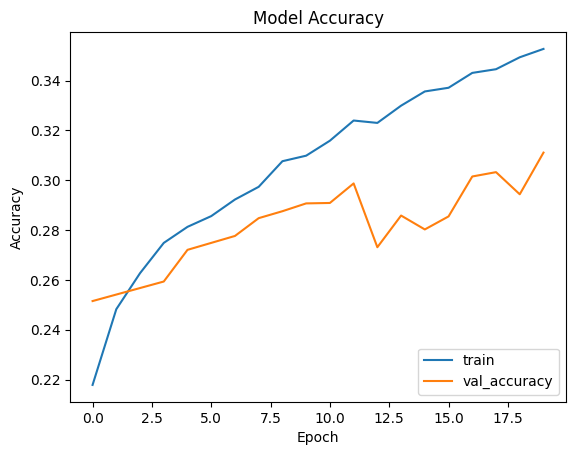

In [ ]:
plt.plot(cnn_history2.history['accuracy'])
plt.plot(cnn_history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val_accuracy'], loc='lower right')
plt.show()

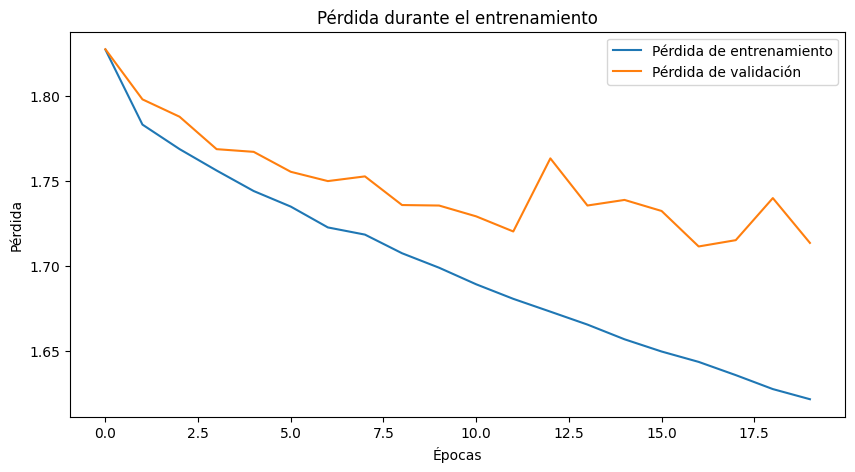

In [ ]:
train_loss = cnn_history2.history['loss']
val_loss = cnn_history2.history['val_loss']
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Pérdida de entrenamiento')
plt.plot(val_loss, label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


In [ ]:
test_generator = test_datagen.flow_from_directory(
     "/content/test/test",
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical'
)
test_loss, test_accuracy = cnn_history2.evaluate(test_generator)


Found 7178 images belonging to 7 classes.
113/113 [==============================] - 4s 37ms/step - loss: 1.7198 - accuracy: 0.3080


In [ ]:
print(test_loss, test_accuracy )

1.7198456525802612 0.308024525642395


1/1 [==============================] - 0s 28ms/step


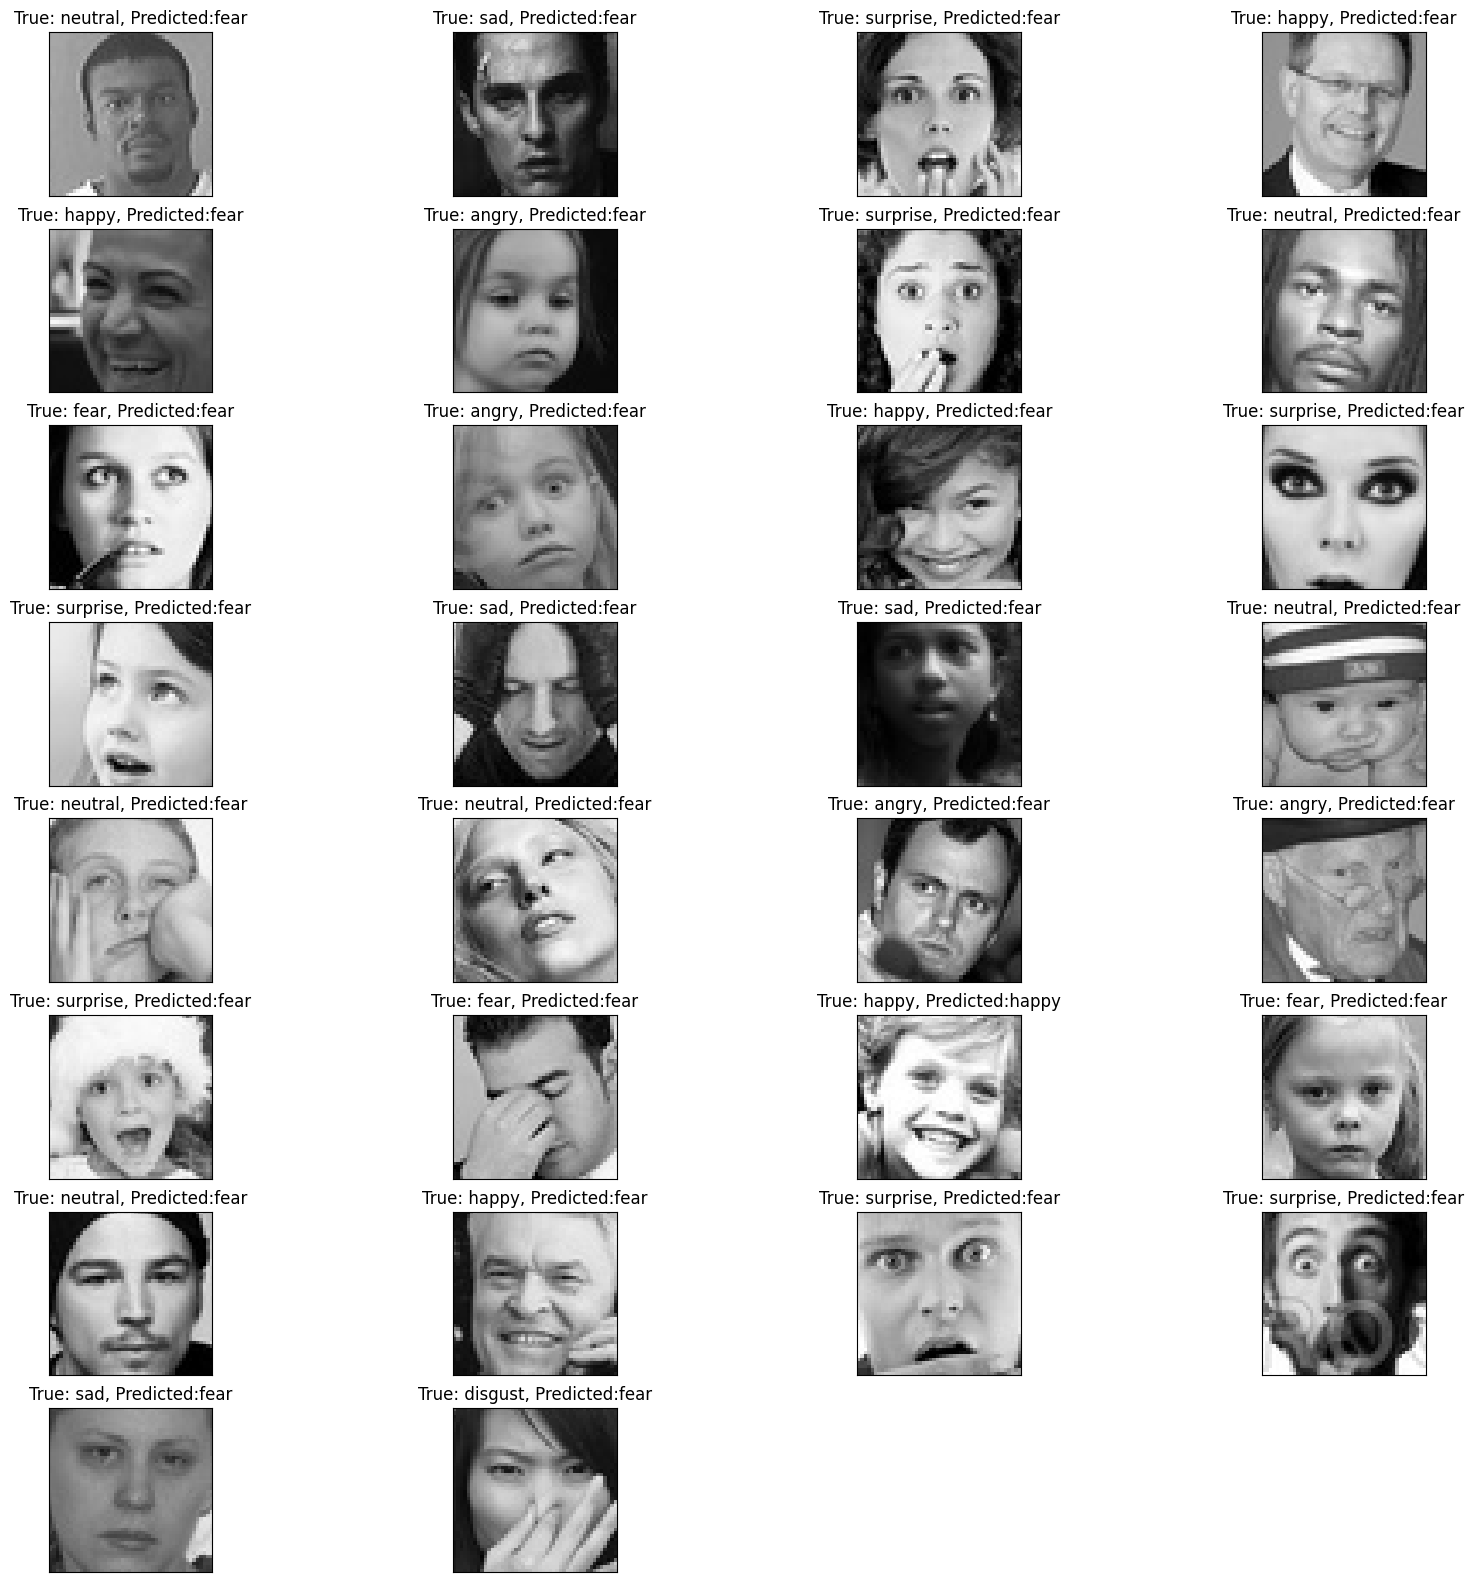

In [ ]:
test_model(model,test_dataset.classes)

##Comparison

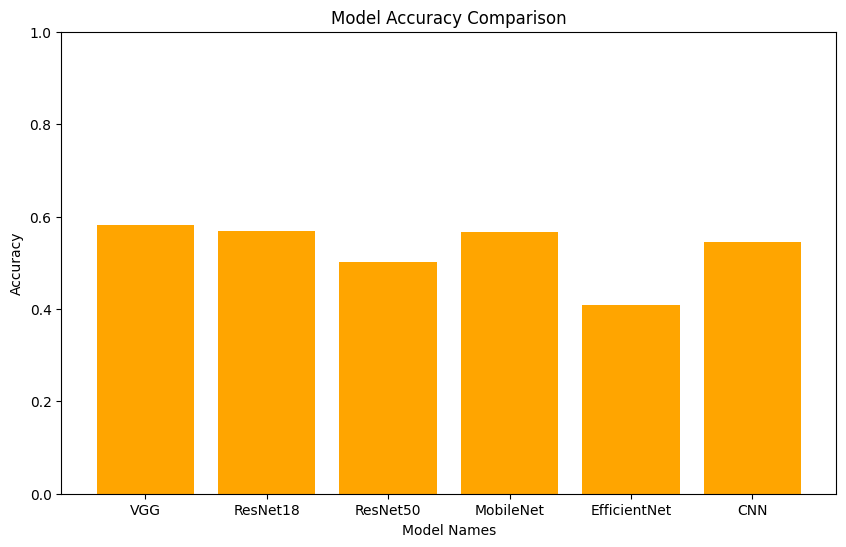

In [ ]:
#plot comparison
import matplotlib.pyplot as plt

model_names = ["VGG", "ResNet18", "ResNet50","MobileNet","EfficientNet","CNN"]
accuracies = [0.58192, 0.5683, 0.5017,0.5658, 0.408 ,0.5447]
# Assign colors based on accuracy
colors = ['green' if acc > 0.53 else 'orange' for acc in accuracies]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=colors)

plt.title('Model Accuracy Comparison')
plt.xlabel('Model Names')
plt.ylabel('Accuracy')

plt.ylim(0, 1)
plt.show()


# Evaluate the best model using a new dataset

Probem quin model funciona millor amb un dataset que no sigui amb el qual hem entrenat

In [ ]:
import zipfile
import os
import shutil

# Paths
zip_folder = data_path+'DiffusionEmotion'
output_dir = data_path+'newDiffusionEmotion'

# Create directories if they don't exist
os.makedirs(output_dir, exist_ok=True)

# Unzipping files and organizing into train and test directories
for zip_file in os.listdir(zip_folder):
    if zip_file.endswith('.zip'):
        zip_path = os.path.join(zip_folder, zip_file)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # Extract to a temporary directory
            temp_dir = os.path.join(output_dir, 'temp')
            zip_ref.extractall(temp_dir)

            # Move files to appropriate train/test directory
            for root, dirs, files in os.walk(temp_dir):
                for file in files:
                    if file.endswith(('.png', '.jpg', '.jpeg')):  # Assuming images
                        label = os.path.basename(root)
                        label_dir = os.path.join(output_dir, label)
                        os.makedirs(label_dir, exist_ok=True)

                        # Move the file to the appropriate directory
                        shutil.move(os.path.join(root, file), os.path.join(label_dir, file))

            # Clean up temporary directory
            shutil.rmtree(temp_dir)


In [ ]:
new_test_dataset = datasets.ImageFolder(output_dir, transform=transform)

# Create data loaders
new_test_loader = DataLoader(new_test_dataset, batch_size=32, shuffle=True)  # Shuffle training data

print(new_test_dataset.classes)

# Get class number
new_classes = len(new_test_dataset.classes)
print(f'There are {new_classes} classes.')

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
There are 7 classes.


In [ ]:
!pip install GPUtil
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7394 sha256=f42b6bcb797e4880b1dc80360b11670133341f249e0924a390675669bbaf8853
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil
Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 97% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 83% |  1% |


In [ ]:
transform = transforms.Compose([
    transforms.Resize((48, 48)),    # Resize images to a common size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean = [.5], std = [.5])
])

dataset = datasets.ImageFolder(output_dir, transform=transform)
testLoader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=False)

vgg16 = VGG16(n_classes=new_classes)
vgg16.load_state_dict(torch.load('cnn.pkl'))
vgg16.cuda()

# Compute accuracy on the new dataset
accuracy_new_data = compute_accuracy(testLoader)
print(f'Accuracy on the new dataset: {accuracy_new_data:.2f}%')

NameError: name 'VGG16' is not defined

In [ ]:
# Load the new dataset using ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)  # You may need to specify other preprocessing steps
test_generator = test_datagen.flow_from_directory(
    output_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',  # Assuming you have categorical labels
    shuffle=False  # Important: Do not shuffle the test data
)

# Evaluate the model on the new dataset
test_loss_rn, test_accuracy_rn, test_precision_rn, test_recall_rn, test_auc_rn, test_f1_score_rn = resnet_model.evaluate(test_generator)            #resnet model

print(f'Test Loss: {test_loss_rn:.4f}')
print(f'Test Accuracy: {test_accuracy_rn:.4f}')
print(f'Test Precision: {test_precision_rn:.4f}')
print(f'Test Recall: {test_recall_rn:.4f}')
print(f'Test AUC: {test_auc_rn:.4f}')
print(f'Test F1 Score: {test_f1_score_rn:.4f}')

test_loss_brn, test_accuracy_brn, test_precision_brn, test_recall_brn, test_auc_brn, test_f1_score_brn = better_resnet_model.evaluate(test_generator)     #better resnet model

print(f'Test Loss: {test_loss_brn:.4f}')
print(f'Test Accuracy: {test_accuracy_brn:.4f}')
print(f'Test Precision: {test_precision_brn:.4f}')
print(f'Test Recall: {test_recall_brn:.4f}')
print(f'Test AUC: {test_auc_brn:.4f}')
print(f'Test F1 Score: {test_f1_score_brn:.4f}')

test_loss_effn, test_accuracy_effn, test_precision_effn, test_recall_effn, test_auc_effn, test_f1_score_effn = effn_model.evaluate(test_generator)              #efficientnet model

print(f'Test Loss: {test_loss_effn:.4f}')
print(f'Test Accuracy: {test_accuracy_effn:.4f}')
print(f'Test Precision: {test_precision_effn:.4f}')
print(f'Test Recall: {test_recall_effn:.4f}')
print(f'Test AUC: {test_auc_effn:.4f}')
print(f'Test F1 Score: {test_f1_score_effn:.4f}')

Found 1292 images belonging to 7 classes.
41/41 [==============================] - 22s 474ms/step - loss: 1.9319 - accuracy: 0.8571 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6200 - f1_score: 0.0000e+00
Test Loss: 1.9319
Test Accuracy: 0.8571
Test Precision: 0.0000
Test Recall: 0.0000
Test AUC: 0.6200
Test F1 Score: 0.0000
41/41 [==============================] - 20s 481ms/step - loss: 1.9791 - accuracy: 0.8571 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4554 - f1_score: 0.0000e+00
Test Loss: 1.9791
Test Accuracy: 0.8571
Test Precision: 0.0000
Test Recall: 0.0000
Test AUC: 0.4554
Test F1 Score: 0.0000
41/41 [==============================] - 20s 463ms/step - loss: 1.9087 - accuracy: 0.8571 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6113 - f1_score: 0.0000e+00
Test Loss: 1.9087
Test Accuracy: 0.8571
Test Precision: 0.0000
Test Recall: 0.0000
Test AUC: 0.6113
Test F1 Score: 0.0000


#Conitnuous Loading

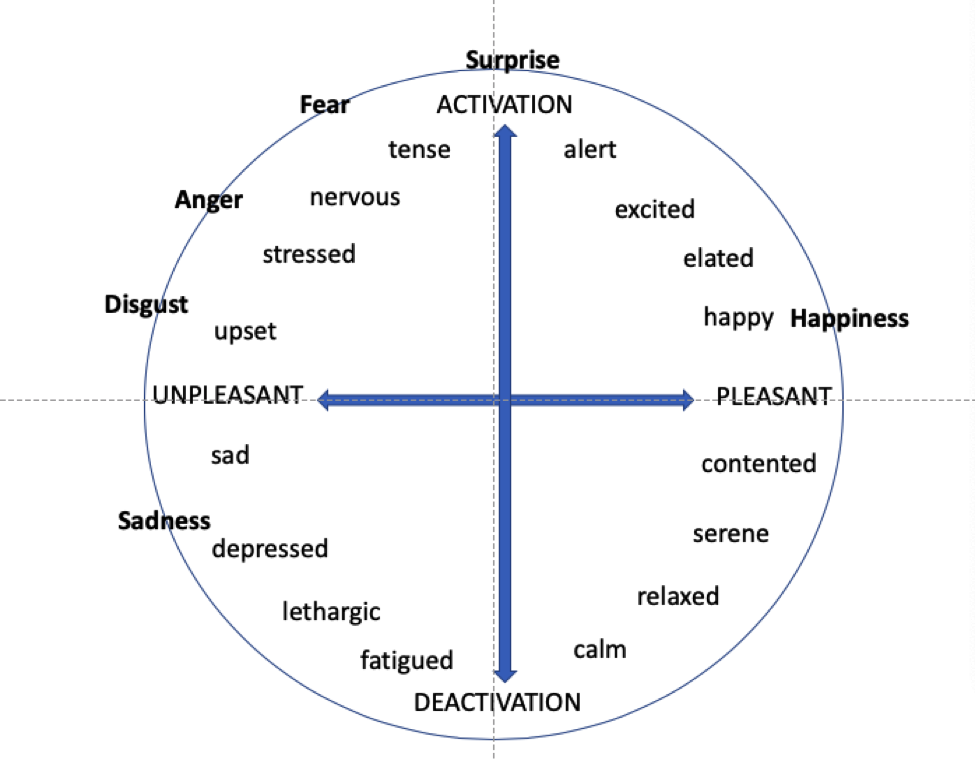

In [ ]:
import numpy as np
import os
import shutil
import pandas as pd

# Define the ranges for valence and arousal based on the circumplex model
emotion_ranges = {
    0: {'valence': (-0.1, 0.1), 'arousal': (-0.1, 0.1)},  # Neutral
    1: {'valence': (0.7, 1.0), 'arousal': (0.2, 0.5)},  # Happiness
    2: {'valence': (-1.0, -0.5), 'arousal': (-0.5, -0.3)},  # Sadness
    3: {'valence': (-0.9, -0.7), 'arousal': (0.6, 0.8)},  # Anger
    4: {'valence': (-0.8, -0.6), 'arousal': (0.7, 0.9)},  # Fear
    5: {'valence': (-0.1, 0.3), 'arousal': (0.7, 1.0)},  # Surprise
    6: {'valence': (-1.0, -0.8), 'arousal': (0.1, 0.4)},  # Disgust
}
# Function to generate random valence and arousal within specified ranges
def generate_random_valence_arousal(emotion):
    valence_range = emotion_ranges[emotion]['valence']
    arousal_range = emotion_ranges[emotion]['arousal']
    valence = np.random.uniform(valence_range[0], valence_range[1])
    arousal = np.random.uniform(arousal_range[0], arousal_range[1])
    return valence, arousal


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformation
transform = transforms.Compose([
    # transforms.Resize((48, 48)),    # Resize images to a common size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean = [.5], std = [.5])
])

# Load datasets
train_dataset = datasets.ImageFolder('/content/train/train', transform=transform)
test_dataset = datasets.ImageFolder('/content/test/test', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)   #shuffle=True to improve generalization and prevent the model from learning the order of the data
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)    #suffle=False to ensure consistent and reproducible evaluation metrics

# Check the class names
print(train_dataset.classes)
print(test_dataset.classes)
classes = test_dataset.classes

# Get class number
n_classes = len(train_dataset.classes)
print(f'There are {n_classes} classes.')

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
There are 7 classes.


In [ ]:
# Create new directories for the continuous dataset
new_train_path = '/content/continuous_train'
new_test_path = '/content/continuous_test'
os.makedirs(new_train_path, exist_ok=True)
os.makedirs(new_test_path, exist_ok=True)

# Function to save new dataset
def save_new_dataset(dataset, new_path):
    continuous_labels = []

    # Iterate over the dataset
    for img_path, label in dataset.samples:
        # Generate random valence and arousal
        valence, arousal = generate_random_valence_arousal(label)

        # Get the original filename
        filename = os.path.basename(img_path)

        # Create a new path for the image
        class_name = dataset.classes[label]
        class_path = os.path.join(new_path, class_name)
        os.makedirs(class_path, exist_ok=True)
        new_img_path = os.path.join(class_path, filename)
        shutil.copyfile(img_path, new_img_path)

        # Save continuous label
        continuous_labels.append({
            'image_path': new_img_path,
            'valence': valence,
            'arousal': arousal,
            'class': class_name
        })

    # Save continuous labels to a CSV file at the root of the new dataset folder
    labels_df = pd.DataFrame(continuous_labels)
    csv_path = os.path.join(new_path, 'labels.csv')
    labels_df.to_csv(csv_path, index=False)
    print(f"Archivo CSV guardado en: {csv_path}")

# Save the new datasets
save_new_dataset(train_dataset, new_train_path)       #possar .dataset in case of ResNet18
save_new_dataset(test_dataset, new_test_path)
from google.colab import files

# Descargar el archivo CSV del conjunto de entrenamiento
files.download(os.path.join(new_train_path, 'labels.csv'))

# Descargar el archivo CSV del conjunto de prueba
files.download(os.path.join(new_test_path, 'labels.csv'))

Archivo CSV guardado en: /content/continuous_train/labels.csv
Archivo CSV guardado en: /content/continuous_test/labels.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[.5], std=[.5])
])

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.classes = self.dataframe['class'].unique()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        class_label = self.dataframe.iloc[idx]['class']
        valence = self.dataframe.iloc[idx]['valence']
        arousal = self.dataframe.iloc[idx]['arousal']

        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, valence,arousal,class_label

# Leer el CSV
train_csv_path = '/content/continuous_train/labels.csv'
test_csv_path = '/content/continuous_test/labels.csv'
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Crear conjuntos de datos personalizados
train_dataset_continous = CustomImageDataset(train_df, transform=transform)
test_dataset_continous = CustomImageDataset(test_df, transform=transform)

# Crear cargadores de datos
train_loader_continous = DataLoader(train_dataset_continous, batch_size=32, shuffle=True)
test_loader_continous = DataLoader(test_dataset_continous, batch_size=32, shuffle=False)

# Verificar las clases en los conjuntos de datos cargados
print(train_dataset_continous.classes)
print(test_dataset_continous.classes)

# Imprimir todos los elementos de la primera fila del conjunto de datos de entrenamiento
print(train_dataset_continous[0])
print(train_loader_continous)

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
(tensor([[[-0.6078, -0.7490, -0.8824,  ...,  0.0431,  0.1843, -0.3255],
         [-0.5529, -0.7333, -0.8275,  ...,  0.0824,  0.1843, -0.3020],
         [-0.5216, -0.7647, -0.8118,  ...,  0.1137,  0.1686, -0.3020],
         ...,
         [-0.1922, -0.2157, -0.2157,  ...,  0.1686, -0.1843, -0.3333],
         [-0.1608, -0.1294, -0.1137,  ...,  0.1843, -0.0588, -0.3255],
         [-0.1843, -0.1843, -0.1216,  ...,  0.1216,  0.0667, -0.3490]],

        [[-0.6078, -0.7490, -0.8824,  ...,  0.0431,  0.1843, -0.3255],
         [-0.5529, -0.7333, -0.8275,  ...,  0.0824,  0.1843, -0.3020],
         [-0.5216, -0.7647, -0.8118,  ...,  0.1137,  0.1686, -0.3020],
         ...,
         [-0.1922, -0.2157, -0.2157,  ...,  0.1686, -0.1843, -0.3333],
         [-0.1608, -0.1294, -0.1137,  ...,  0.1843, -0.0588, -0.3255],
         [-0.1843, -0.1843, -0.1216,  ...,  0.1216,  0.0667, -0.

# Continuous Models

### VGG11

In [ ]:
import torch
import torch.nn as tnn
import torch.optim as toptim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import confusion_matrix

LEARNING_RATE = 0.001
EPOCH = 10
PATIENCE = 5  # Early stopping patience

# Assuming train_dataset_continous and test_dataset_continous are defined

trainLoader = torch.utils.data.DataLoader(dataset=train_dataset_continous, batch_size=32, shuffle=True)
testLoader = torch.utils.data.DataLoader(dataset=test_dataset_continous, batch_size=32, shuffle=False)

def vgg_fc_layer(size_in, size_out, p=0.5):
    layer = tnn.Sequential(
        tnn.Linear(size_in, size_out),
        tnn.BatchNorm1d(size_out),
        tnn.ReLU(),
        tnn.Dropout(p=p)  # Adding dropout with a probability of p
    )
    return layer

def compute_accuracy(data_loader):
    vgg11.eval()
    correct_valence_pred, correct_arousal_pred, num_examples = 0, 0, 0
    for batch_idx, (images, valence, arousal, discrete_labels) in enumerate(data_loader):
        images = images.cuda()
        valence = valence.cuda()
        arousal = arousal.cuda()
        _, outputs = vgg11(images)
        valence_preds = outputs[:, 0]
        arousal_preds = outputs[:, 1]

        correct_valence_pred += ((valence_preds - valence).abs() < 0.5).sum().item()
        correct_arousal_pred += ((arousal_preds - arousal).abs() < 0.5).sum().item()
        num_examples += valence.size(0) + arousal.size(0)

    total_correct = correct_valence_pred + correct_arousal_pred
    accuracy = total_correct / num_examples * 100
    return accuracy

class VGG11_cont(tnn.Module):
    def __init__(self, n_classes=2):
        super(VGG11_cont, self).__init__()

        self.block_1 = tnn.Sequential(
            tnn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=1),
            tnn.ReLU(),
            tnn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )

        self.block_2 = tnn.Sequential(
            tnn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=1),
            tnn.ReLU(),
            tnn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )

        self.block_3 = tnn.Sequential(
            tnn.Conv2d(in_channels=32, out_channels=64, kernel_size=(2, 2), stride=(1, 1), padding=1),
            tnn.ReLU(),
            tnn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )

        self.block_4 = tnn.Sequential(
            tnn.Conv2d(in_channels=64, out_channels=128, kernel_size=(2, 2), stride=(1, 1), padding=1),
            tnn.ReLU(),
            tnn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )

        self.block_5 = tnn.Sequential(
            tnn.Conv2d(in_channels=128, out_channels=256, kernel_size=(2, 2), stride=(1, 1), padding=1),
            tnn.ReLU(),
            tnn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )

        # FC layers with dropout
        self.layer7 = vgg_fc_layer(1024, 4096, p=0.5)
        self.layer8 = vgg_fc_layer(4096, n_classes, p=0.5)

    def forward(self, x):
        out = self.block_1(x)
        out = self.block_2(out)
        out = self.block_3(out)
        out = self.block_4(out)
        vgg16_features = self.block_5(out)
        out = vgg16_features.view(out.size(0), -1)
        out = self.layer7(out)
        out = self.layer8(out)
        out = torch.tanh(out)
        return vgg16_features, out

vgg11 = VGG11_cont().cuda()

# Use Adam optimizer with weight decay for regularization
optimizer = toptim.AdamW(vgg11.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, patience=3, factor=0.5)  # Reduce LR on plateau

# Early stopping criteria
best_accuracy = 0
patience_counter = 0

# Training loop
for epoch in range(EPOCH):
    avg_loss = 0
    vgg11.train()
    for batch_idx, (images, valence, arousal, discrete_labels) in enumerate(trainLoader):
        images = images.cuda()
        valence = valence.cuda()
        arousal = arousal.cuda()
        discrete_labels = discrete_labels  # No need to move discrete labels to GPU as they're not used in training

        _, outputs = vgg11(images)

        # Forward + Backward + Optimize
        loss_valence = tnn.MSELoss()(outputs[:, 0], valence.float())
        loss_arousal = tnn.MSELoss()(outputs[:, 1], arousal.float())
        loss = loss_valence + loss_arousal
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ### LOGGING
        if not batch_idx % 150:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f (Valence), %.4f (Arousal)'
                  % (epoch+1, EPOCH, batch_idx,
                     len(trainLoader), loss_valence, loss_arousal))
        avg_loss += loss.item()

    avg_loss /= len(trainLoader)

    vgg11.eval()
    with torch.set_grad_enabled(False):  # save memory during inference
        accuracy = compute_accuracy(testLoader)
        print('Epoch: %03d/%03d | Accuracy: %.3f%% ' % (epoch+1, EPOCH, accuracy))

    scheduler.step(avg_loss)

    # Check early stopping criteria
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        patience_counter = 0
        torch.save(vgg11.state_dict(), 'best_model.pkl')
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE:
        print("Early stopping triggered")
        break

# Load the best model for evaluation
vgg11.load_state_dict(torch.load('best_model.pkl'))
vgg11.eval()


Epoch: 001/010 | Batch 0000/0898 | Loss: 0.8078 (Valence), 0.3461 (Arousal)
Epoch: 001/010 | Batch 0150/0898 | Loss: 0.5945 (Valence), 0.2825 (Arousal)
Epoch: 001/010 | Batch 0300/0898 | Loss: 0.6478 (Valence), 0.3967 (Arousal)
Epoch: 001/010 | Batch 0450/0898 | Loss: 0.5539 (Valence), 0.3058 (Arousal)
Epoch: 001/010 | Batch 0600/0898 | Loss: 0.3570 (Valence), 0.3366 (Arousal)
Epoch: 001/010 | Batch 0750/0898 | Loss: 0.4481 (Valence), 0.2606 (Arousal)
Epoch: 001/010 | Accuracy: 42.379% 
Epoch: 002/010 | Batch 0000/0898 | Loss: 0.4266 (Valence), 0.1616 (Arousal)
Epoch: 002/010 | Batch 0150/0898 | Loss: 0.4621 (Valence), 0.3129 (Arousal)
Epoch: 002/010 | Batch 0300/0898 | Loss: 0.4736 (Valence), 0.2131 (Arousal)
Epoch: 002/010 | Batch 0450/0898 | Loss: 0.4041 (Valence), 0.3204 (Arousal)
Epoch: 002/010 | Batch 0600/0898 | Loss: 0.4430 (Valence), 0.2805 (Arousal)
Epoch: 002/010 | Batch 0750/0898 | Loss: 0.4508 (Valence), 0.3413 (Arousal)
Epoch: 002/010 | Accuracy: 44.978% 
Epoch: 003/010 |

VGG11_cont(
  (block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_5): Sequential(
    (0): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPo

### CNN

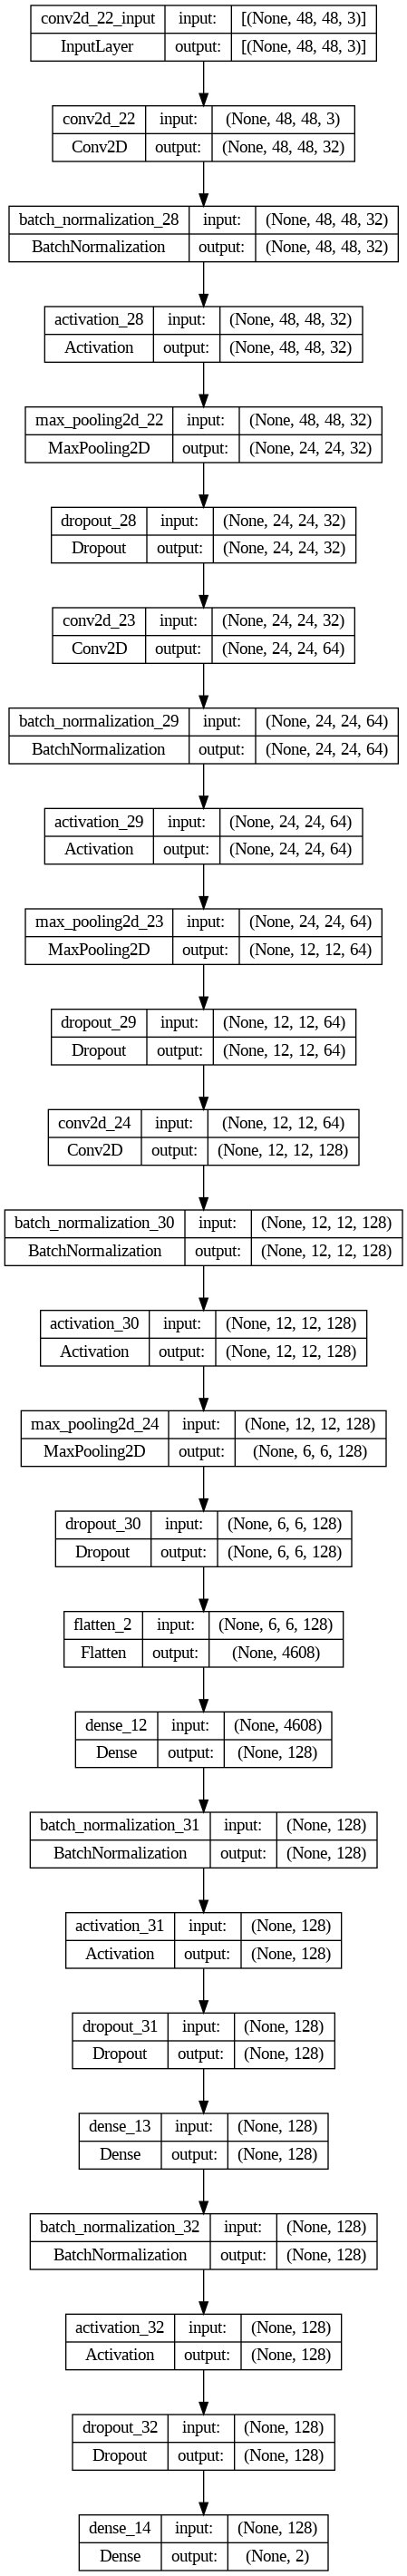

In [ ]:

cnn_model_regression = Sequential()

cnn_model_regression.add(Conv2D(32, (3, 3), padding='same', input_shape=(48, 48, 3)))
cnn_model_regression.add(BatchNormalization())
cnn_model_regression.add(Activation('relu'))
cnn_model_regression.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_regression.add(Dropout(0.25))

cnn_model_regression.add(Conv2D(64, (3, 3), padding='same'))
cnn_model_regression.add(BatchNormalization())
cnn_model_regression.add(Activation('relu'))
cnn_model_regression.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_regression.add(Dropout(0.25))

cnn_model_regression.add(Conv2D(128, (3, 3), padding='same'))
cnn_model_regression.add(BatchNormalization())
cnn_model_regression.add(Activation('relu'))
cnn_model_regression.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_regression.add(Dropout(0.25))


cnn_model_regression.add(Flatten())
cnn_model_regression.add(Dense(128))
cnn_model_regression.add(BatchNormalization())
cnn_model_regression.add(Activation('relu'))
cnn_model_regression.add(Dropout(0.5))

cnn_model_regression.add(Dense(128))
cnn_model_regression.add(BatchNormalization())
cnn_model_regression.add(Activation('relu'))
cnn_model_regression.add(Dropout(0.5))

cnn_model_regression.add(Dense(2, activation='linear'))

optimizer = Adam(learning_rate=0.001)

cnn_model_regression.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae', 'mse'])

plot_model(cnn_model_regression, to_file='cnn2_model_regression.png', show_shapes=True, show_layer_names = True)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001)



In [ ]:

img_width, img_height = 48, 48
batch_size = 64

no_of_classes = 2

In [ ]:
from google.colab import drive
import os
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Verify the path
path = '/content/continuous_train/labels.csv'
if os.path.exists(path):
    print(f"File found: {path}")
    # Read the CSV file
    df = pd.read_csv(path)
    print(df.head())
else:
    print(f"File not found: {path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File found: /content/continuous_train/labels.csv
                                          image_path   valence   arousal  \
0  /content/continuous_train/angry/Training_10118... -0.071450 -0.001780   
1  /content/continuous_train/angry/Training_10120... -0.061482 -0.001633   
2  /content/continuous_train/angry/Training_10131...  0.082608 -0.049345   
3  /content/continuous_train/angry/Training_10161... -0.052450  0.050438   
4  /content/continuous_train/angry/Training_10218... -0.032429 -0.038699   

   class  
0  angry  
1  angry  
2  angry  
3  angry  
4  angry  


In [ ]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class CustomDataGenerator(Sequence):
    def __init__(self, csv_file, img_dir, batch_size, img_size, shuffle=True, subset='training', validation_split=0.2):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.subset = subset
        self.validation_split = validation_split

        # Split the data into training and validation
        self.train_df = self.df.sample(frac=1-validation_split, random_state=42)
        self.valid_df = self.df.drop(self.train_df.index)

        if subset == 'training':
            self.data = self.train_df
        else:
            self.data = self.valid_df

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_data = self.data.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_data)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            self.data = self.data.sample(frac=1).reset_index(drop=True)

    def __data_generation(self, batch_data):
        X = np.empty((self.batch_size, *self.img_size, 3), dtype=np.float32)
        y = np.empty((self.batch_size, 2), dtype=np.float32)

        for i, (_, row) in enumerate(batch_data.iterrows()):
            img_path = os.path.join(self.img_dir, row['image_path'])
            image = load_img(img_path, target_size=self.img_size)
            image = img_to_array(image) / 255.0

            X[i,] = image
            y[i,] = [row['valence'], row['arousal']]

        return X, y


In [ ]:
img_width, img_height = 48, 48
batch_size = 64
img_dir = '/content/continuous_train/'
csv_file = '/content/continuous_train/labels.csv'

train_generator = CustomDataGenerator(csv_file, img_dir, batch_size, (img_width, img_height), subset='training')
validation_generator = CustomDataGenerator(csv_file, img_dir, batch_size, (img_width, img_height), subset='validation')


In [ ]:
cnn_history = cnn_model_regression.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20
358/358 [==============================] - 21s 49ms/step - loss: 0.7178 - mae: 0.6436 - mse: 0.7178 - val_loss: 0.2040 - val_mae: 0.4179 - val_mse: 0.2040 - lr: 0.0010
Epoch 2/20
358/358 [==============================] - 18s 50ms/step - loss: 0.2444 - mae: 0.4133 - mse: 0.2444 - val_loss: 0.1979 - val_mae: 0.4061 - val_mse: 0.1979 - lr: 0.0010
Epoch 3/20
358/358 [==============================] - 18s 51ms/step - loss: 0.2054 - mae: 0.3918 - mse: 0.2054 - val_loss: 0.1940 - val_mae: 0.3991 - val_mse: 0.1940 - lr: 0.0010
Epoch 4/20
358/358 [==============================] - 17s 49ms/step - loss: 0.1975 - mae: 0.3869 - mse: 0.1975 - val_loss: 0.1926 - val_mae: 0.3974 - val_mse: 0.1926 - lr: 0.0010
Epoch 5/20
358/358 [==============================] - 18s 49ms/step - loss: 0.1943 - mae: 0.3832 - mse: 0.1943 - val_loss: 0.1883 - val_mae: 0.3846 - val_mse: 0.1883 - lr: 0.0010
Epoch 6/20
358/358 [==============================] - 18s 50ms/step - loss: 0.1925 - mae: 0.3804 - mse: 0

### ResNet18

In [ ]:
import pandas as pd
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Define transformation
transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.RandomHorizontalFlip(),            # Apply horizontal flip
    transforms.RandomRotation(5),                 # Apply random rotation (degrees) -> important to set a small angle
    transforms.ToTensor(),                        # Convert images to PyTorch tensors
    transforms.Normalize(mean = [.5], std = [.5])
])


class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.classes = self.dataframe['class'].unique()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        class_label = self.dataframe.iloc[idx]['class']
        valence = self.dataframe.iloc[idx]['valence']
        arousal = self.dataframe.iloc[idx]['arousal']

        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, valence,arousal,class_label

# Leer el CSV
train_csv_path = '/content/continuous_train/labels.csv'
test_csv_path = '/content/continuous_test/labels.csv'
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Crear conjuntos de datos personalizados
train_dataset_continous = CustomImageDataset(train_df, transform=transform)
test_dataset_continous = CustomImageDataset(test_df, transform=transform)

# Crear cargadores de datos
train_loader_continous = DataLoader(train_dataset_continous, batch_size=64, shuffle=True)
test_loader_continous = DataLoader(test_dataset_continous, batch_size=64, shuffle=False)

# Verificar las clases en los conjuntos de datos cargados
print(train_dataset_continous.classes)
print(test_dataset_continous.classes)

# Imprimir todos los elementos de la primera fila del conjunto de datos de entrenamiento
print(train_dataset_continous[0])
print(train_loader_continous)

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
(tensor([[[-0.3255,  0.1843,  0.0431,  ..., -0.8824, -0.7490, -0.6078],
         [-0.3020,  0.1843,  0.0824,  ..., -0.8275, -0.7333, -0.5529],
         [-0.3020,  0.1686,  0.1137,  ..., -0.8118, -0.7647, -0.5216],
         ...,
         [-0.3333, -0.1843,  0.1686,  ..., -0.2157, -0.2157, -0.1922],
         [-0.3255, -0.0588,  0.1843,  ..., -0.1137, -0.1294, -0.1608],
         [-0.3490,  0.0667,  0.1216,  ..., -0.1216, -0.1843, -0.1843]],

        [[-0.3255,  0.1843,  0.0431,  ..., -0.8824, -0.7490, -0.6078],
         [-0.3020,  0.1843,  0.0824,  ..., -0.8275, -0.7333, -0.5529],
         [-0.3020,  0.1686,  0.1137,  ..., -0.8118, -0.7647, -0.5216],
         ...,
         [-0.3333, -0.1843,  0.1686,  ..., -0.2157, -0.2157, -0.1922],
         [-0.3255, -0.0588,  0.1843,  ..., -0.1137, -0.1294, -0.1608],
         [-0.3490,  0.0667,  0.1216,  ..., -0.1216, -0.1843, -0.

In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score as f1_score_sklearn

# Define the Mean Absolut Error
def compute_mae(outputs, valence, arousal):
    with torch.no_grad():  # No necesitamos gradientes para esto
        valence_error = torch.abs(outputs[:, 0] - valence)
        arousal_error = torch.abs(outputs[:, 1] - arousal)
        mae = torch.mean(valence_error + arousal_error) / 2
    return mae.item()


def train_model_continuous(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, device='cuda', patience=5):
    best_val_f1 = 0
    best_model_weights = None
    train_metrics_history = []      #return history
    val_metrics_history = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_mae = 0.0

        for inputs, valence, arousal, labels in train_loader:
            inputs = inputs.to(device)
            valence = valence.to(device).float()
            arousal = arousal.to(device).float()

            optimizer.zero_grad()

            #Forward
            outputs = model(inputs)
            loss = criterion(outputs, torch.stack((valence, arousal), dim=1))

            #Backward + optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_mae += compute_mae(outputs, valence, arousal) * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_mae = running_mae / len(train_loader.dataset)

        print(f'Epoch {epoch}/{num_epochs - 1} Loss: {epoch_loss:.4f} MAE: {epoch_mae:.4f}')

    return model

def plot_confusion_matrix(targets, predictions, classes):
    cm = confusion_matrix(targets, np.argmax(predictions, axis=1))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def test_model_continuous(model, dataloader, criterion):
    model.eval()  # Modo de evaluación
    running_loss = 0.0
    all_predicted_valence = []
    all_predicted_arousal = []

    with torch.no_grad():  # No necesitamos calcular gradientes
        for inputs, valence, arousal, _ in dataloader:
            inputs = inputs.to(device)
            valence = valence.to(device)
            arousal = arousal.to(device)

            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, torch.stack((valence, arousal), dim=1))

            # Almacenar predicciones
            all_predicted_valence.extend(outputs[:, 0].cpu().numpy())
            all_predicted_arousal.extend(outputs[:, 1].cpu().numpy())

            # Estadísticas
            running_loss += loss.item() * inputs.size(0)

    final_loss = running_loss / len(dataloader.dataset)
    print(f'Test Loss: {final_loss:.4f}')

    return all_predicted_valence, all_predicted_arousal

def test_model(model, dataloader, criterion, emotion_ranges):
    model.eval()  # Modo de evaluación
    running_loss = 0.0
    all_predicted_valence = []
    all_predicted_arousal = []
    all_predicted_classes = []  # Lista para almacenar las clases predichas

    with torch.no_grad():  # No necesitamos calcular gradientes
        for inputs, valence, arousal, _ in dataloader:
            inputs = inputs.to(device)
            valence = valence.to(device)
            arousal = arousal.to(device)

            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, torch.stack((valence, arousal), dim=1))

            # Almacenar predicciones
            all_predicted_valence.extend(outputs[:, 0].cpu().numpy())
            all_predicted_arousal.extend(outputs[:, 1].cpu().numpy())

            # Clasificar las emociones basadas en los rangos de valencia y excitación
            for val, aro in zip(outputs[:, 0], outputs[:, 1]):
                for emotion, ranges in emotion_ranges.items():
                    if ranges['valence'][0] <= val <= ranges['valence'][1] and ranges['arousal'][0] <= aro <= ranges['arousal'][1]:
                        all_predicted_classes.append(emotion)
                        break

            # Estadísticas
            running_loss += loss.item() * inputs.size(0)

    final_loss = running_loss / len(dataloader.dataset)
    print(f'Test Loss: {final_loss:.4f}')

    return all_predicted_valence, all_predicted_arousal, all_predicted_classes

In [ ]:
# Cargar el modelo preentrenado ResNet18
resnet18 = models.resnet18(pretrained=True)

# Congelar todos los parámetros del modelo para evitar que se actualicen durante el entrenamiento
for param in resnet18.parameters():
    param.requires_grad = False

# Reemplazar la última capa FC para adaptarla a la salida continua
# En este caso, la salida será de 2 valores: valencia y excitación (arousal)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 2)

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()                            # Mean Squared Error Loss
optimizer = torch.optim.Adam(resnet18.fc.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)
trained_model = train_model_continuous(resnet18, train_loader_continous, test_loader_continous, criterion, optimizer)



Epoch 0/24 Loss: 0.2819 MAE: 0.4298
Epoch 1/24 Loss: 0.2043 MAE: 0.3822
Epoch 2/24 Loss: 0.2048 MAE: 0.3818
Epoch 3/24 Loss: 0.2027 MAE: 0.3800
Epoch 4/24 Loss: 0.2033 MAE: 0.3799
Epoch 5/24 Loss: 0.2017 MAE: 0.3790
Epoch 6/24 Loss: 0.2034 MAE: 0.3804
Epoch 7/24 Loss: 0.1994 MAE: 0.3764
Epoch 8/24 Loss: 0.2031 MAE: 0.3792
Epoch 9/24 Loss: 0.2010 MAE: 0.3777
Epoch 10/24 Loss: 0.2008 MAE: 0.3774
Epoch 11/24 Loss: 0.2006 MAE: 0.3778
Epoch 12/24 Loss: 0.2015 MAE: 0.3782
Epoch 13/24 Loss: 0.2022 MAE: 0.3782
Epoch 14/24 Loss: 0.1994 MAE: 0.3758
Epoch 15/24 Loss: 0.1998 MAE: 0.3759
Epoch 16/24 Loss: 0.2013 MAE: 0.3768
Epoch 17/24 Loss: 0.2010 MAE: 0.3774
Epoch 18/24 Loss: 0.1992 MAE: 0.3759
Epoch 19/24 Loss: 0.2017 MAE: 0.3769
Epoch 20/24 Loss: 0.1987 MAE: 0.3753
Epoch 21/24 Loss: 0.2013 MAE: 0.3767
Epoch 22/24 Loss: 0.2018 MAE: 0.3779
Epoch 23/24 Loss: 0.2009 MAE: 0.3765
Epoch 24/24 Loss: 0.1997 MAE: 0.3761


Test Loss: 0.1982


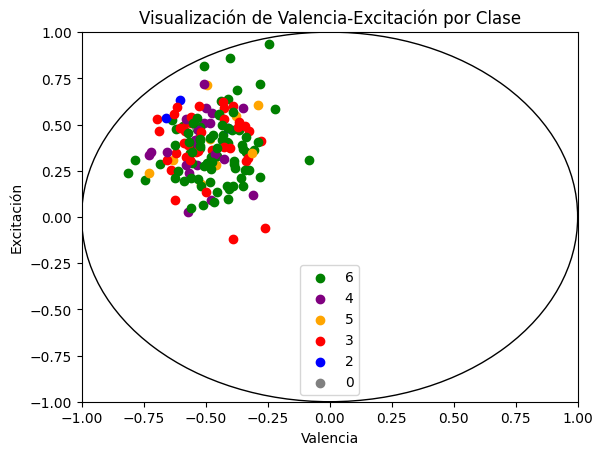

In [ ]:
predicted_valence, predicted_arousal, predicted_classes = test_model(trained_model, test_loader_continous, criterion, emotion_ranges)


colors = {
    0: 'grey',
    1: 'yellow',
    2: 'blue',
    3: 'red',
    4: 'purple',
    5: 'orange',
    6: 'green'
}

# Crear la figura y el eje para el círculo de valencia-excitación
fig, ax = plt.subplots()

# Dibujar un círculo que represente los límites de valencia y excitación
circle = plt.Circle((0, 0), 1, color='black', fill=False)
ax.add_artist(circle)

# Añadir los puntos predichos a la gráfica con colores correspondientes a las clases
for val, aro, cls in zip(predicted_valence, predicted_arousal, predicted_classes):
    ax.scatter(val, aro, color=colors[cls], label=cls)

# Eliminar etiquetas duplicadas en la leyenda
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

# Establecer límites y etiquetas
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_xlabel('Valence')
ax.set_ylabel('Arousal')
ax.set_title('Valence-Arousal visualization per Class')

# Mostrar la gráfica
plt.show()

#Data Aumentation: GANs

In [ ]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [ ]:
# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 48

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 30

# Learning rate for optimizers
lr = 0.001

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

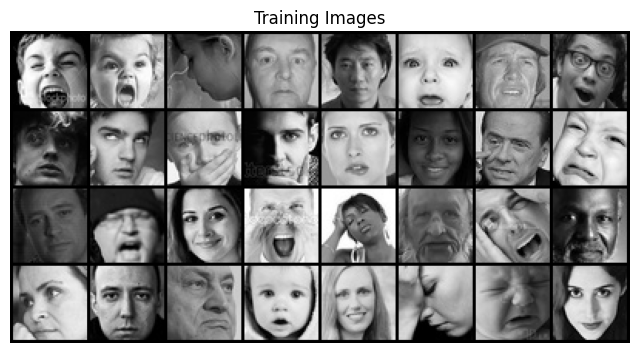

In [ ]:
# Create the dataset
dataset = dset.ImageFolder(root='/content/train/train',
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

**Weight initialization:** From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02.The function takes the initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.

In [ ]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 3, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 3 x 3
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 6 x 6
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 12 x 12
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 24 x 24
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 48 x 48
        )

    def forward(self, input):
        return self.main(input)



In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):  # A binary classification network
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input is (nc) x 64 x 64
            nn.utils.spectral_norm(nn.Conv2d(nc, ndf, 3, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),

            # State size. (ndf) x 32 x 32
            nn.utils.spectral_norm(nn.Conv2d(ndf, ndf * 2, 3, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),

            # State size. (ndf*2) x 16 x 16
            nn.utils.spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),

            # State size. (ndf*4) x 8 x 8
            nn.utils.spectral_norm(nn.Conv2d(ndf * 4, ndf * 8, 3, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),

            # State size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 3, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout(p=0.2, inplace=False)
    (14): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1), bi

In [ ]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
import torch
import numpy as np
import random

# Set seeds for reproducibility
torch.manual_seed(1)
np.random.seed(1)
random.seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)

# Ensure deterministic behavior for CuDNN
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(False)

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        #print('bsize:',real_cpu.size())
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        #print('label1:',label.size())
        # Forward pass real batch through D
        output = netD(real_cpu)
        #print('output1:',output.size())
        # Calculate loss on all-real batch
        errD_real = criterion(output.view(-1), label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        #print('Fake:',fake.size())
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach())

        #print('Output:',output.size())
        #print('Label:',label.size())

        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output.view(-1), label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/30][0/898]	Loss_D: 1.3371	Loss_G: 1.9075	D(x): 0.5154	D(G(z)): 0.4734 / 0.1599
[0/30][50/898]	Loss_D: 0.5703	Loss_G: 3.2220	D(x): 0.7433	D(G(z)): 0.1756 / 0.0440
[0/30][100/898]	Loss_D: 0.8353	Loss_G: 2.4910	D(x): 0.7484	D(G(z)): 0.1901 / 0.1344
[0/30][150/898]	Loss_D: 0.6367	Loss_G: 2.3125	D(x): 0.7349	D(G(z)): 0.2308 / 0.1176
[0/30][200/898]	Loss_D: 1.0008	Loss_G: 2.8688	D(x): 0.6169	D(G(z)): 0.3321 / 0.0667
[0/30][250/898]	Loss_D: 0.8237	Loss_G: 3.9009	D(x): 0.7875	D(G(z)): 0.3436 / 0.0306
[0/30][300/898]	Loss_D: 1.3953	Loss_G: 2.6065	D(x): 0.6714	D(G(z)): 0.5467 / 0.1014
[0/30][350/898]	Loss_D: 1.2585	Loss_G: 2.5256	D(x): 0.6799	D(G(z)): 0.4949 / 0.1275
[0/30][400/898]	Loss_D: 0.9120	Loss_G: 2.3522	D(x): 0.6798	D(G(z)): 0.2938 / 0.1356
[0/30][450/898]	Loss_D: 1.1015	Loss_G: 2.3427	D(x): 0.6003	D(G(z)): 0.3818 / 0.1275
[0/30][500/898]	Loss_D: 0.9922	Loss_G: 2.3043	D(x): 0.7287	D(G(z)): 0.4109 / 0.1250
[0/30][550/898]	Loss_D: 0.7921	Loss_G: 2.4478	D(x): 0

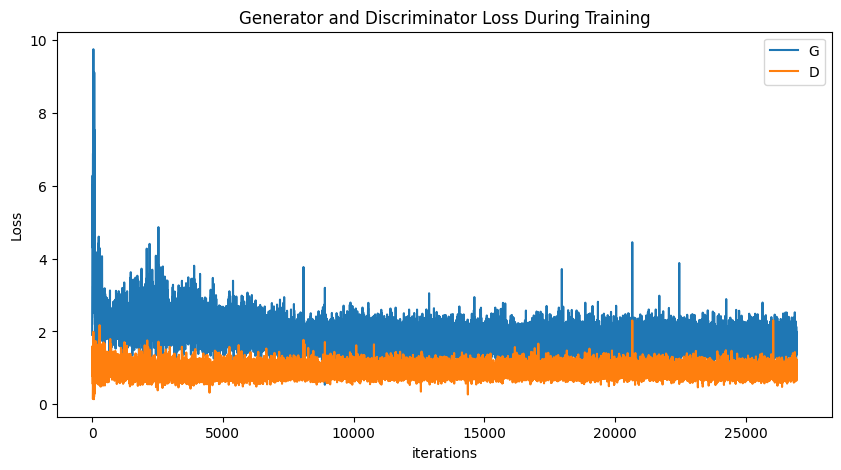

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

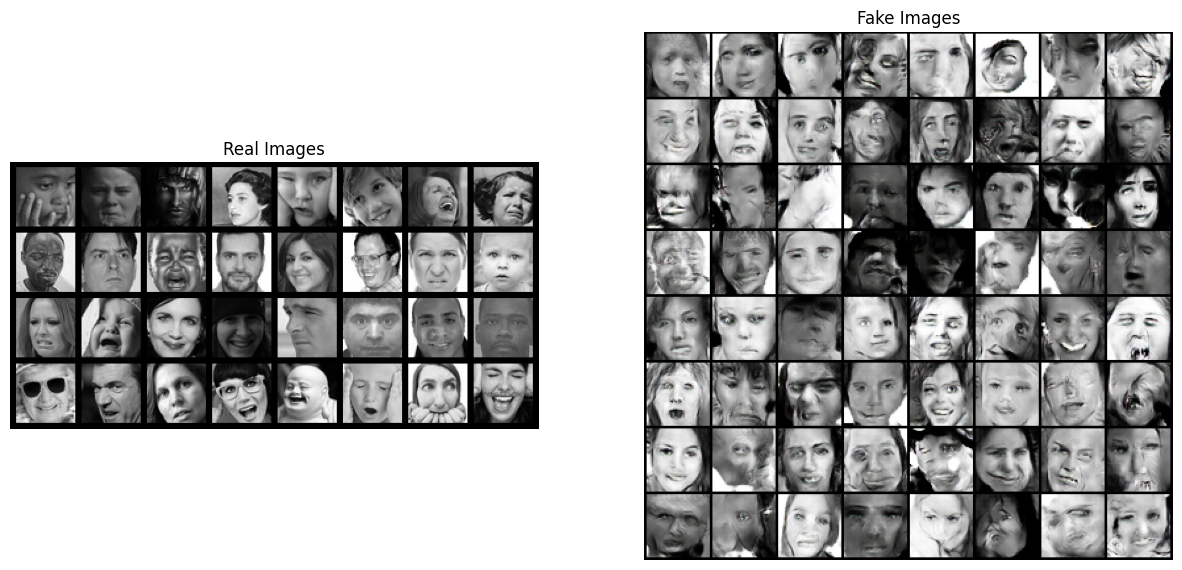

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()